<span style="color:red">Esse Notebook é uma cópia ligeiramente alterada do Notebook no diretório irmão 0_low_penalty</span>

Nesse _Notebook_, iremos testar os hiperparâmetros testados pelas melhores _trials_ do Optuna.


In [1]:
import optuna

/home/guilherme/.local/share/rtx/installs/python/3.11.4/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


3 melhores _trials_ e seus parâmetros


In [2]:
study = optuna.load_study(study_name='ode_feed_forward',
                          storage='sqlite:///ode_feed_forward.db')
best_three = study.trials_dataframe().sort_values(by='value').head(3)
display(best_three)

number     value             datetime_start          datetime_complete  \
71      71  1.825539 2023-07-06 16:26:08.908793 2023-07-06 16:27:20.778526   
34      34  1.869964 2023-07-06 15:36:13.179905 2023-07-06 15:37:23.762053   
64      64  2.035698 2023-07-06 16:16:16.280411 2023-07-06 16:17:39.506360   

                 duration params_activation_l1 params_activation_l2  \
71 0 days 00:01:11.869733                 relu                 relu   
34 0 days 00:01:10.582148                 relu                 relu   
64 0 days 00:01:23.225949                 relu                 relu   

   params_activation_l3  params_learning_rate  params_n_units_l1  \
71               linear              0.006414                  9   
34               linear              0.007838                 10   
64               linear              0.003831                  9   

    params_n_units_l2  params_n_units_l3     state  
71                 10                 10  COMPLETE  
34                  8                  9  COMPLETE  
64                  9                  8  COMPLETE

Constantes: Funções de Ativação: relu, relu e linear

Variados: Learning Rate e quantidade de neurônios.


## Gerando dados de treino


In [3]:
import numpy as np
from scipy.integrate import odeint

N_TRAIN_EXAMPLES = 5000
INTEGRATION_DOMAIN = np.arange(0, 10, 0.01)
BATCH_SIZE = INTEGRATION_DOMAIN.shape[0] - 1


def simple_spectrum(x1_x2, t0):
    x1, x2 = x1_x2
    return [-0.05 * x1, -1.0 * (x2 - x1 ** 2)]


x0_training = -1 + 2 * np.random.random((N_TRAIN_EXAMPLES, 2))
x_training = np.asarray(
    [odeint(simple_spectrum, x0_j, INTEGRATION_DOMAIN) for x0_j in x0_training])
nn_input_training = np.zeros(
    (N_TRAIN_EXAMPLES * (len(INTEGRATION_DOMAIN) - 1), 2))
nn_output_training = np.zeros_like(nn_input_training)
for j in range(N_TRAIN_EXAMPLES):
    nn_input_training[j * (len(INTEGRATION_DOMAIN) - 1): (j + 1)
                      * (len(INTEGRATION_DOMAIN) - 1), :] = x_training[j, :-1, :]
    nn_output_training[j * (len(INTEGRATION_DOMAIN) - 1): (j + 1)
                       * (len(INTEGRATION_DOMAIN) - 1), :] = x_training[j, 1:, :]

## Preparando os três melhores modelos


In [4]:
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam

models = list()
for i in range(3):
    trial = best_three.iloc[i]
    new_model = Sequential()
    new_model.add(Dense(trial['params_n_units_l1'],
                  activation=trial['params_activation_l1']))
    new_model.add(Dense(trial['params_n_units_l2'],
                  activation=trial['params_activation_l2']))
    new_model.add(Dense(trial['params_n_units_l3'],
                  activation=trial['params_activation_l3']))
    new_model.add(Dense(2, activation="linear"))
    new_model.compile(loss='mean_squared_error', optimizer=Adam(
        learning_rate=trial['params_learning_rate']))
    models.append(new_model)

2023-07-08 01:48:21.786695: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-08 01:48:21.818271: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-08 01:48:21.818961: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-08 01:48:22.573051: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-08 01:48:23.107832: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Do

## Treinando cada um dos modelos


In [ ]:
import time
from keras.callbacks import EarlyStopping
EPOCHS = 600 # Diminuído, visto que no modelo anterior o *loss* caiu de forma consideravelmente rápida


# Evitando treinamentos sem convergência
# Diminuído o *patience* para 25
callback = EarlyStopping(monitor='loss', patience=25)

for i, model in enumerate(models):
    start = time.time()
    history_i = model.fit(
        nn_input_training,
        nn_output_training,
        shuffle=True,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[callback],
        verbose=1,
    )
    end = time.time()
    # Salvando modelo
    model.save(f"trained_models/model_{i}.h5")
    # Salvando tempo de treinamento
    with open(f"trained_models/model_{i}_time.txt", "w") as f:
        f.write(f"{end - start}")

## OU (carregando modelos já salvos)


In [6]:
from keras.models import load_model

models = list()
for i in range(3):
    models.append(load_model(f"trained_models/model_{i}.h5"))

## Testando modelos


Comparando desempenho das redes em diferentes amplitudes, com $x_0 \in$:

- $[-1, 1]$
- $[-3, 3]$
- $[-5, 5]$
- $[-10, 10]$


In [ ]:
import numpy as np
from scipy.integrate import odeint

N_TEST_EXAMPLES = 10  # Exemplos para cada amplitude
BOUNDS = [1, 3, 5, 10]  # Diferentes amplitudes utilizadas

x_validation = dict()
for bound in BOUNDS:
    x0_validation = -bound + 2 * bound * np.random.random((N_TEST_EXAMPLES, 2))
    x_validation[bound] = np.asarray(
        [odeint(simple_spectrum, x0_j, INTEGRATION_DOMAIN) for x0_j in x0_validation])

predictions = list()
for i in range(3):
    predictions_i = dict()
    for k, v in x_validation.items():
        predictions_i[k] = np.zeros_like(v)
        predictions_i[k][:, 0, :] = v[:, 0, :]
        for j in range(1, len(INTEGRATION_DOMAIN)):
            predictions_i[k][:, j, :] = models[i].predict(
                predictions_i[k][:, j - 1, :])
    predictions.append(predictions_i)

## [OPCIONAL] (salvando dados de predição)

In [8]:
import h5py

for i in range(3):
  with h5py.File(f"predictions_result/model_{i}_prediction.h5", "w") as f:
    for k, v in predictions[i].items():
      f.create_dataset(f"{k}", data=v)

## [OPCIONAL] (carregando dados de predição)

In [9]:
predictions = list()
for i in range(3):
  predictions_i = dict()
  with h5py.File(f"predictions_result/model_{i}_prediction.h5", "r") as f:
    for k, v in f.items():
      predictions_i[int(k)] = np.asarray(v)
  predictions.append(predictions_i)

## Componentes x tempo



# Rede 1
## Parâmetros utilizados:
- Número de neurônios na camada 1: 9
- Função de ativação na camada 1: relu
- Número de neurônios na camada 2: 10
- Função de ativação na camada 2: relu
- Número de neurônios na camada 3: 10
- Função de ativação na camada 3: linear
- Taxa de aprendizado: 0.006413857489384444


### Amplitude $x_0 \in [-1, 1]$

<Figure size 640x480 with 0 Axes>

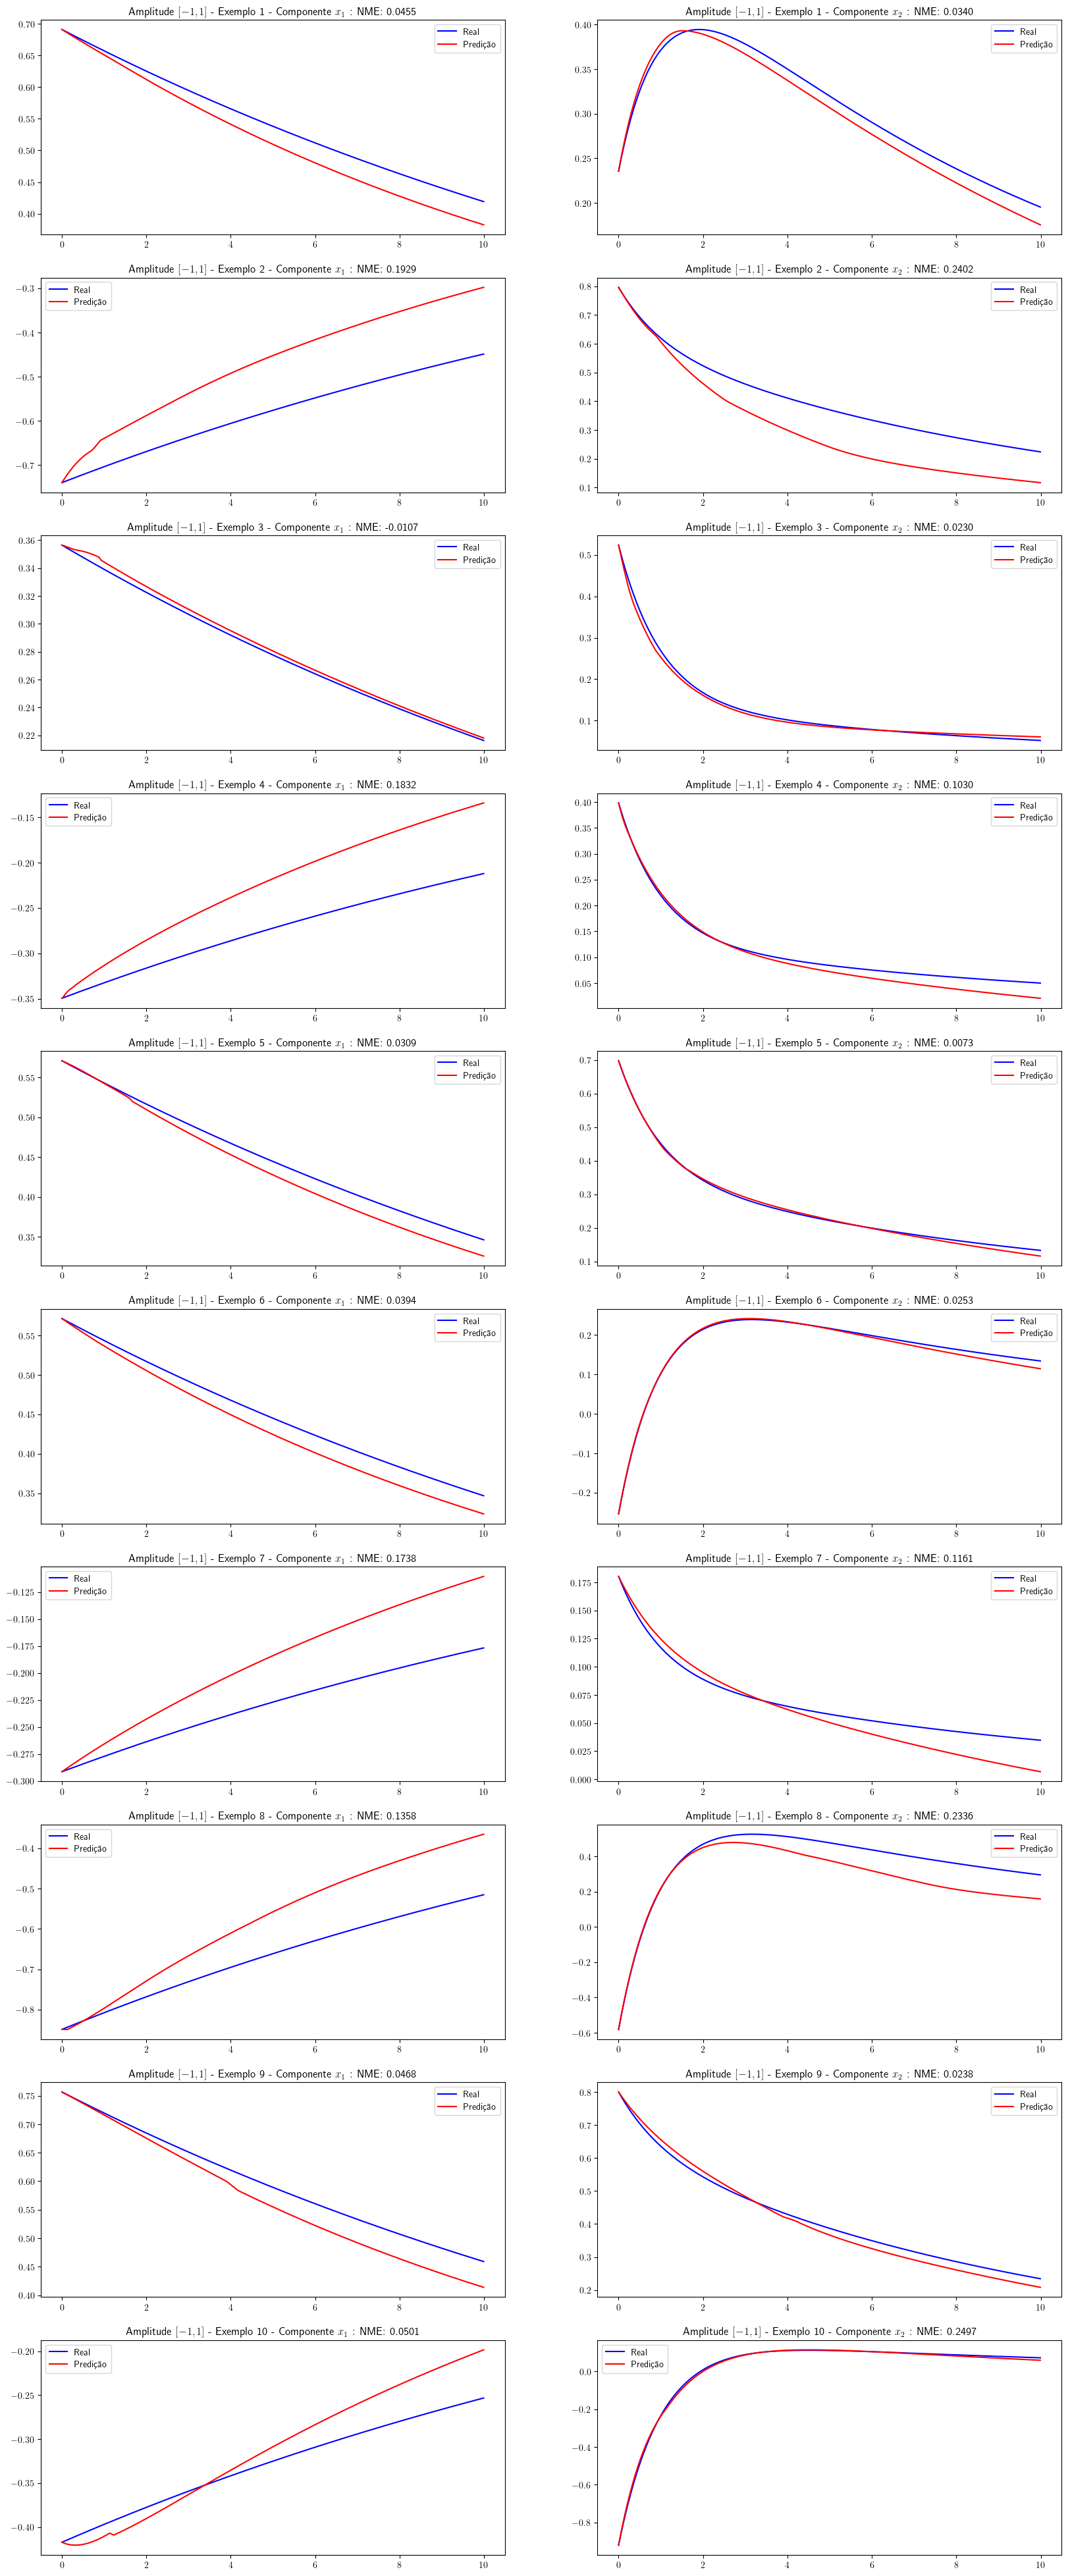

### Amplitude $x_0 \in [-3, 3]$

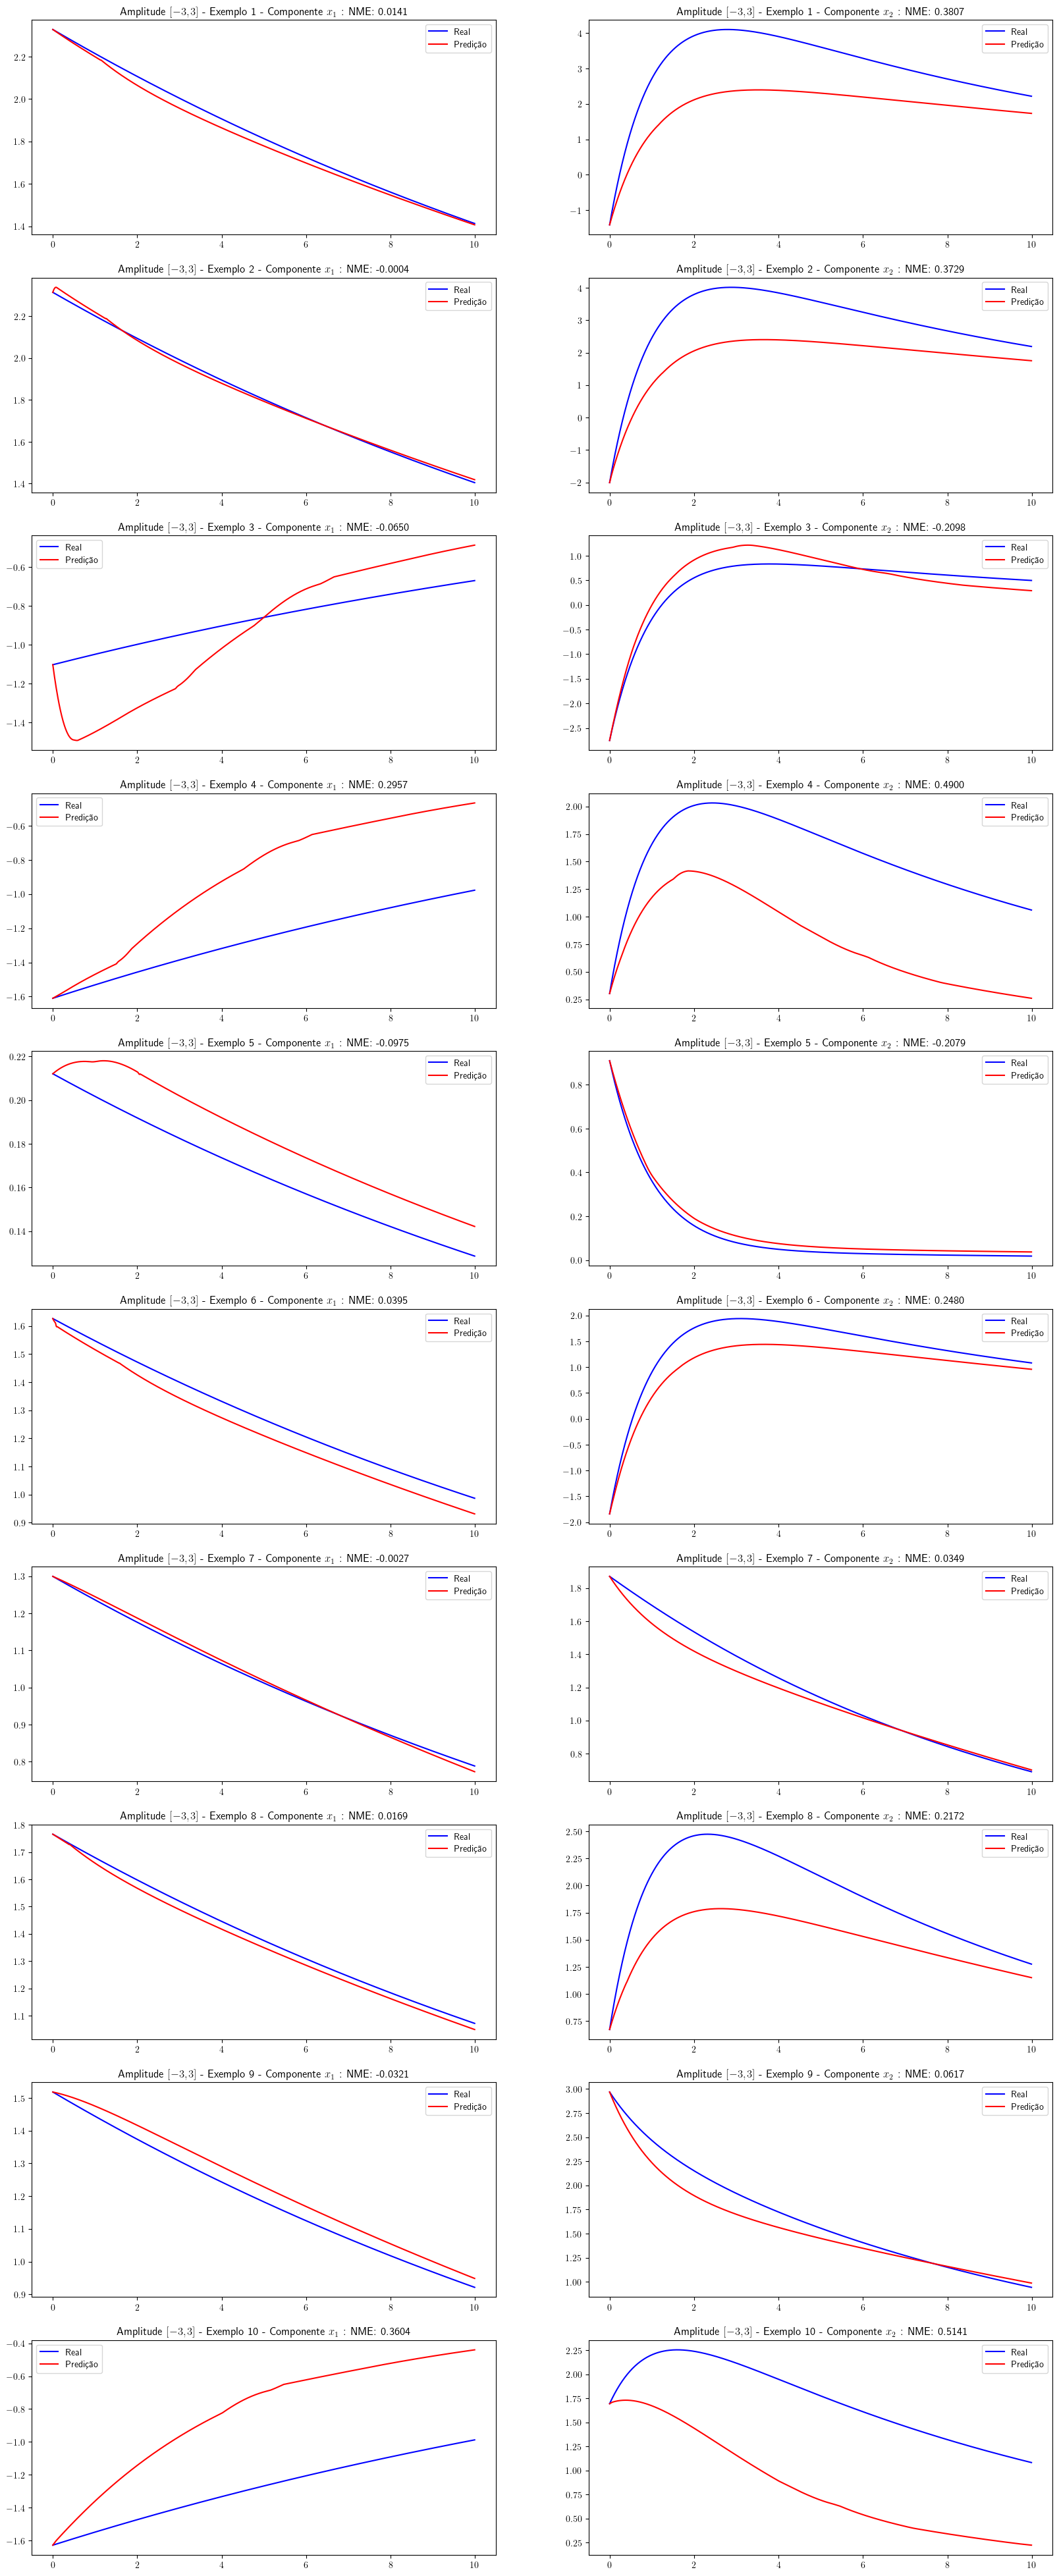

### Amplitude $x_0 \in [-5, 5]$

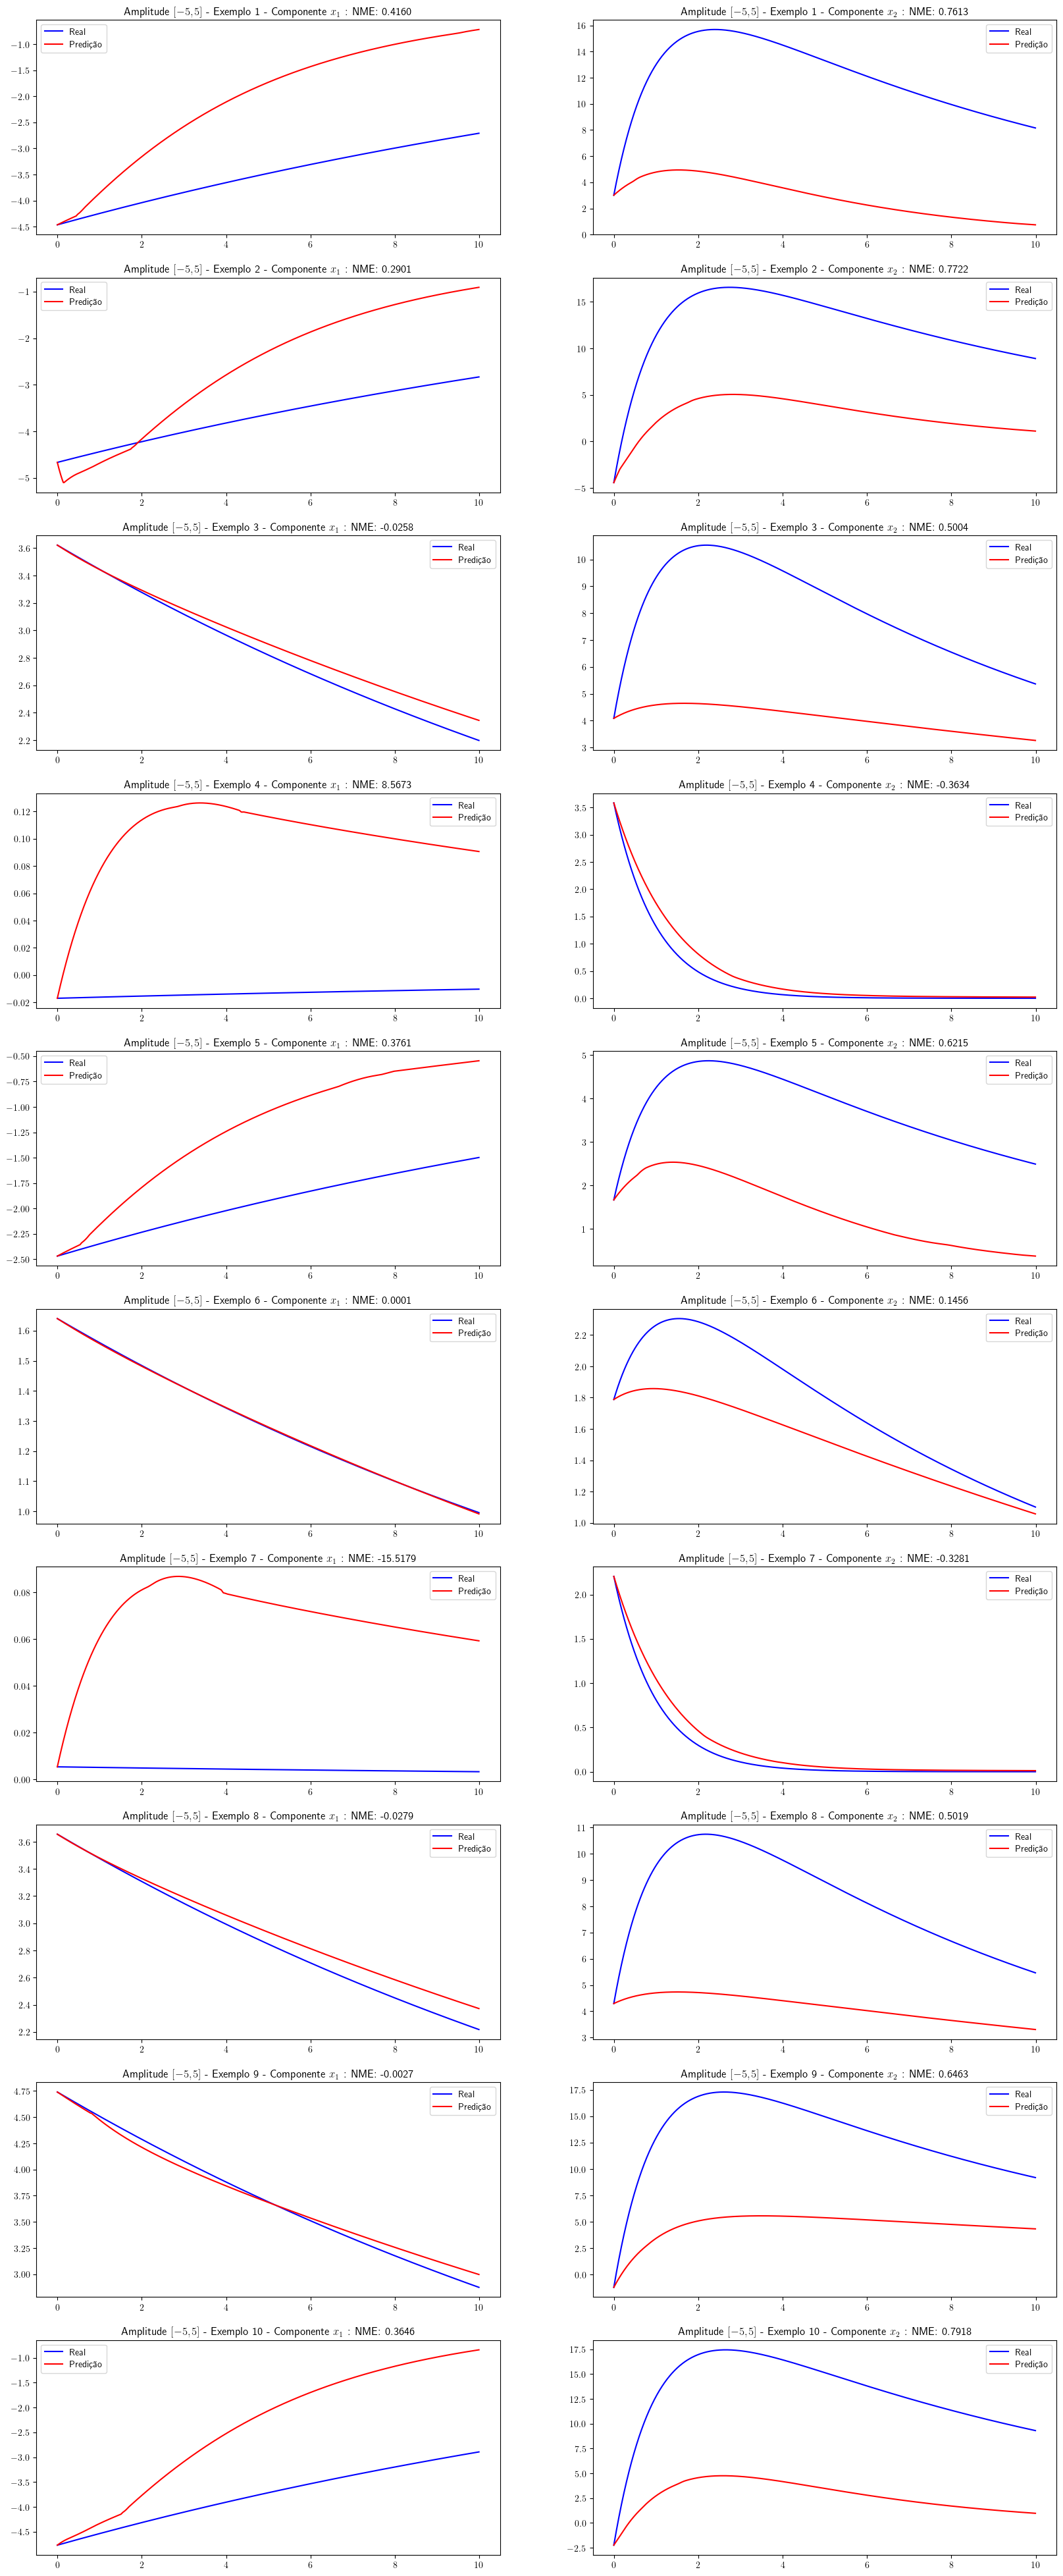

### Amplitude $x_0 \in [-10, 10]$

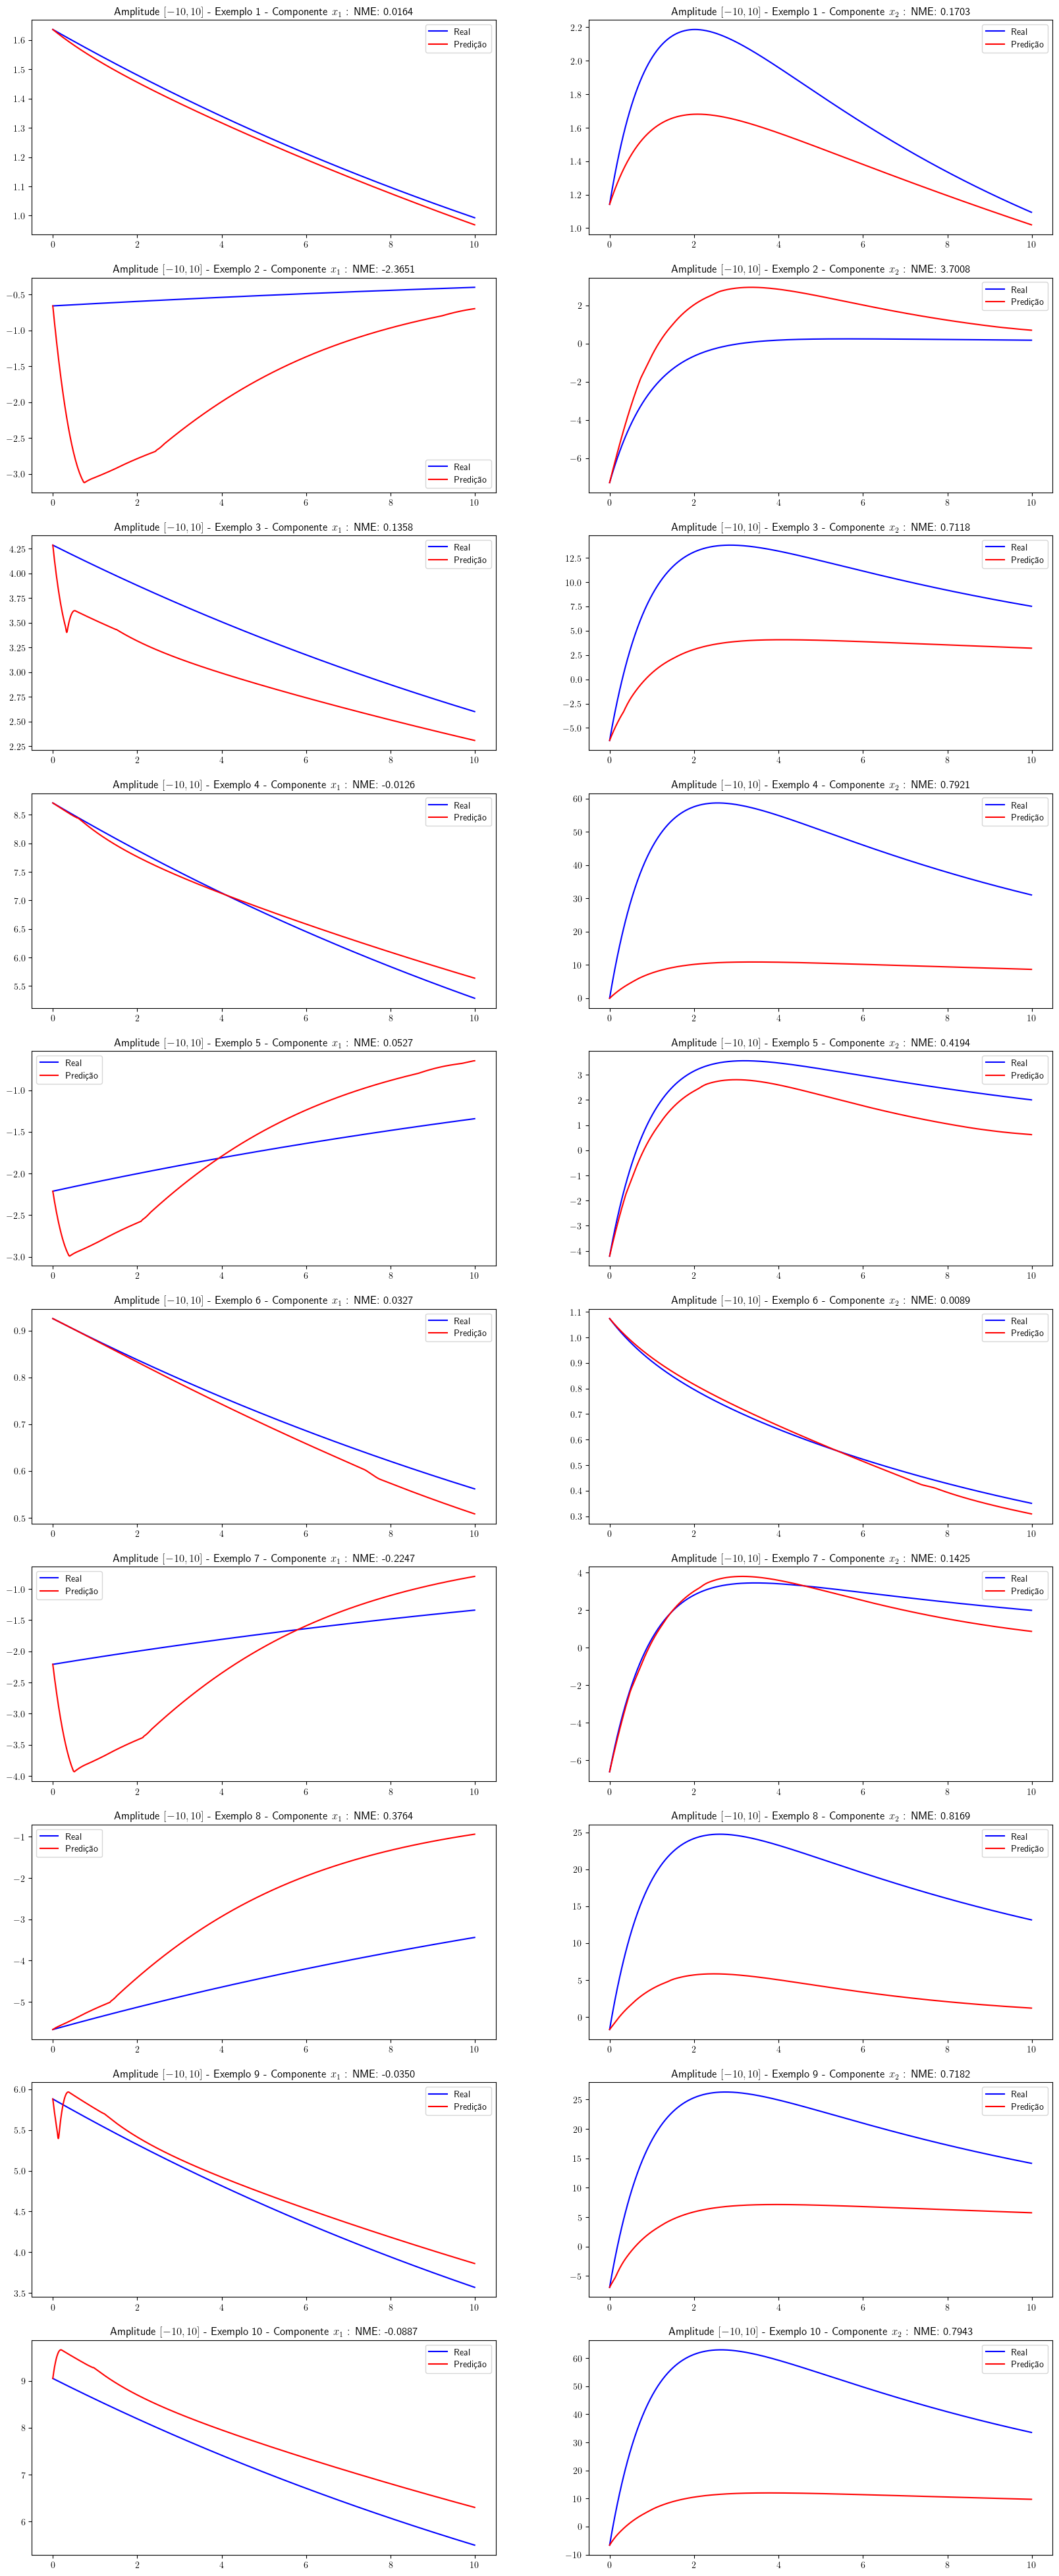


# Rede 2
## Parâmetros utilizados:
- Número de neurônios na camada 1: 10
- Função de ativação na camada 1: relu
- Número de neurônios na camada 2: 8
- Função de ativação na camada 2: relu
- Número de neurônios na camada 3: 9
- Função de ativação na camada 3: linear
- Taxa de aprendizado: 0.007838371147140906


### Amplitude $x_0 \in [-1, 1]$

<Figure size 640x480 with 0 Axes>

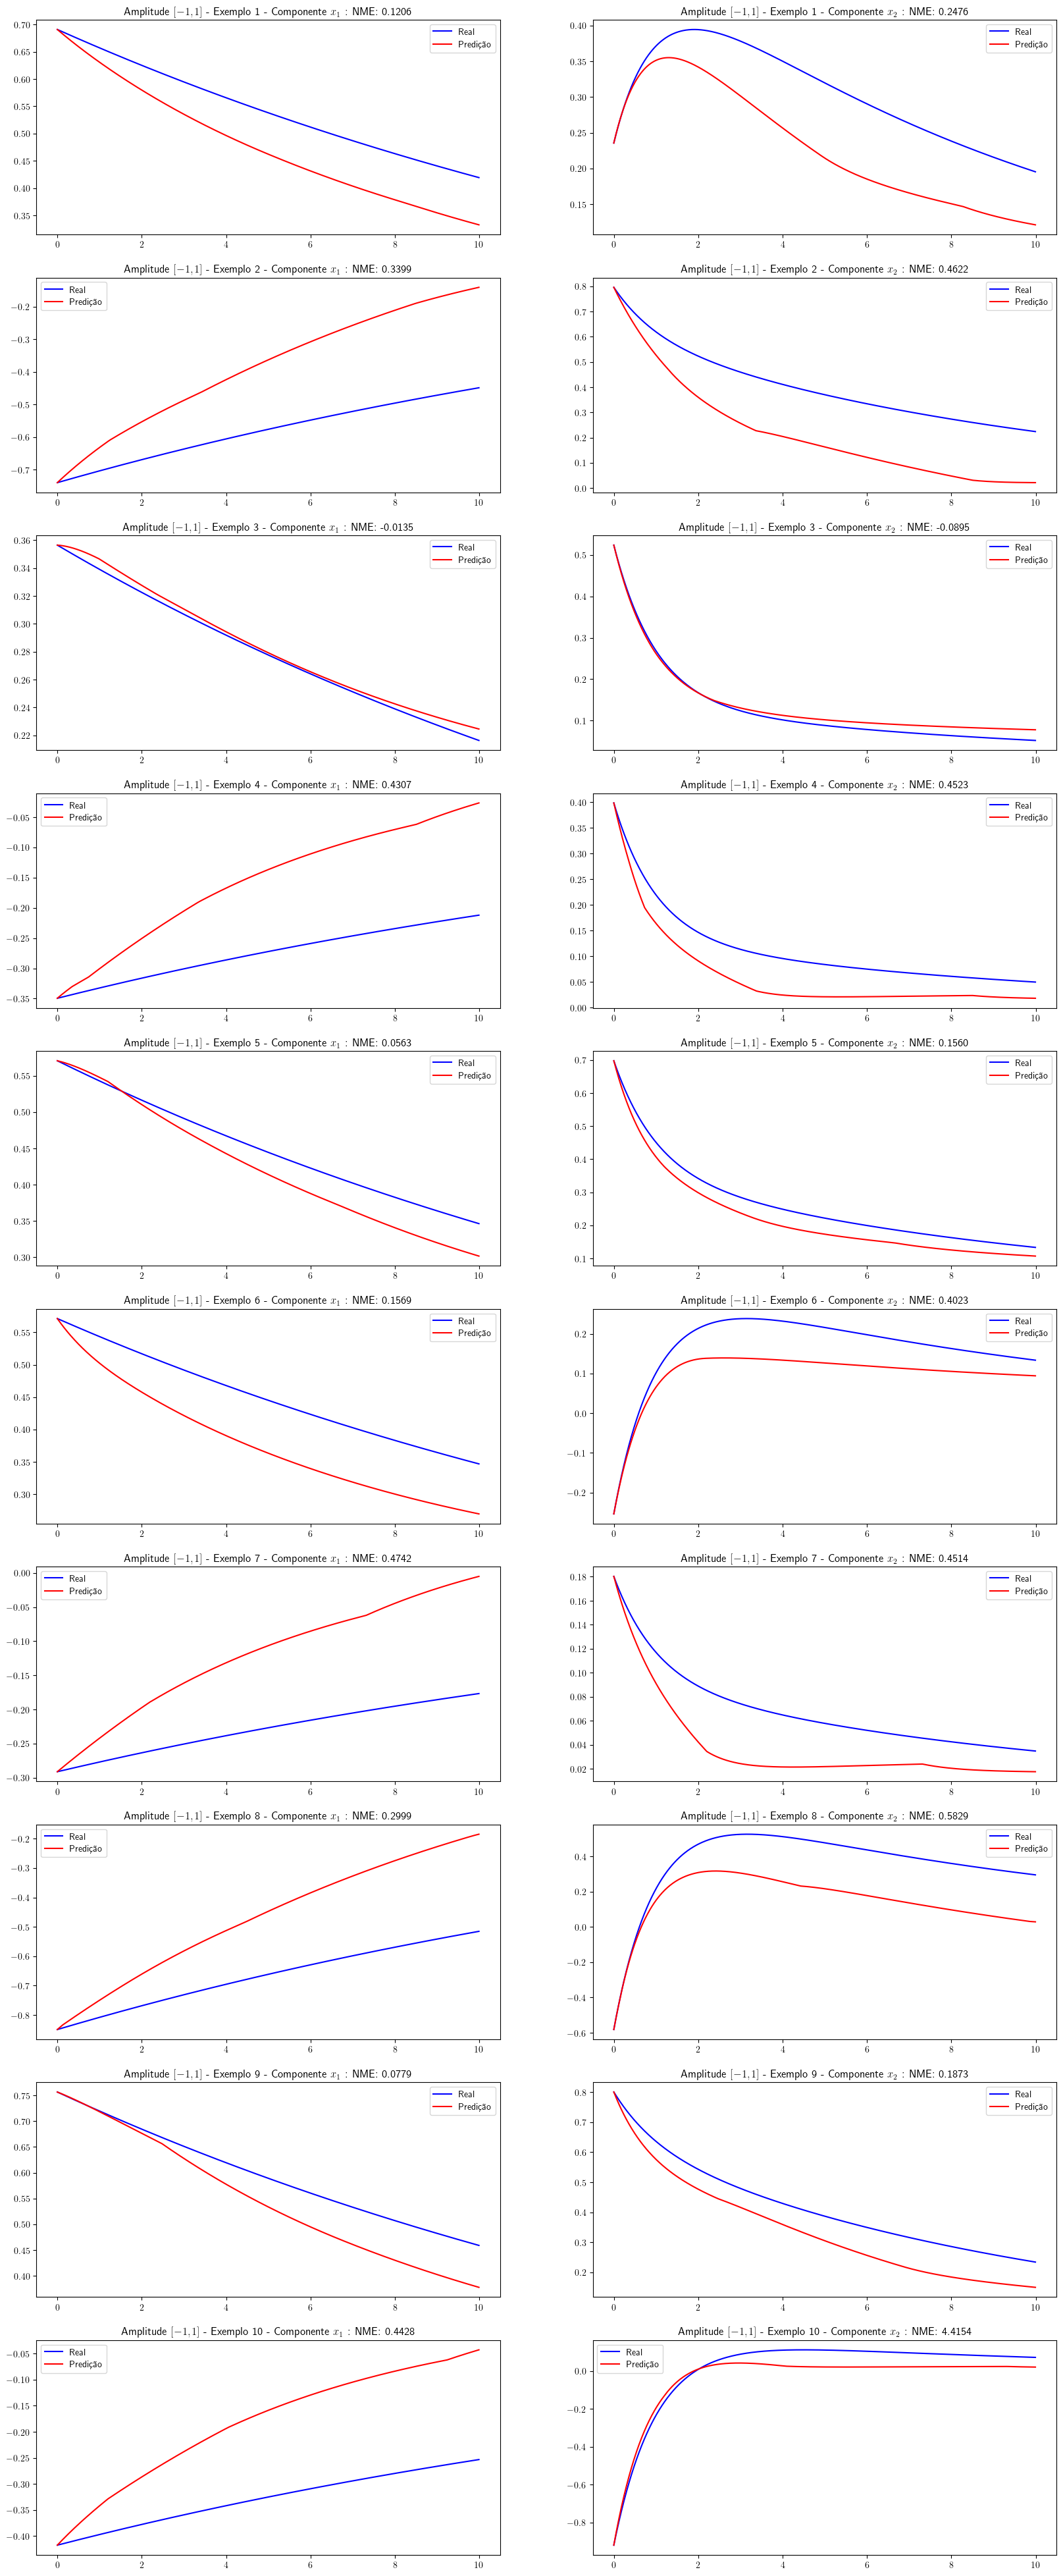

### Amplitude $x_0 \in [-3, 3]$

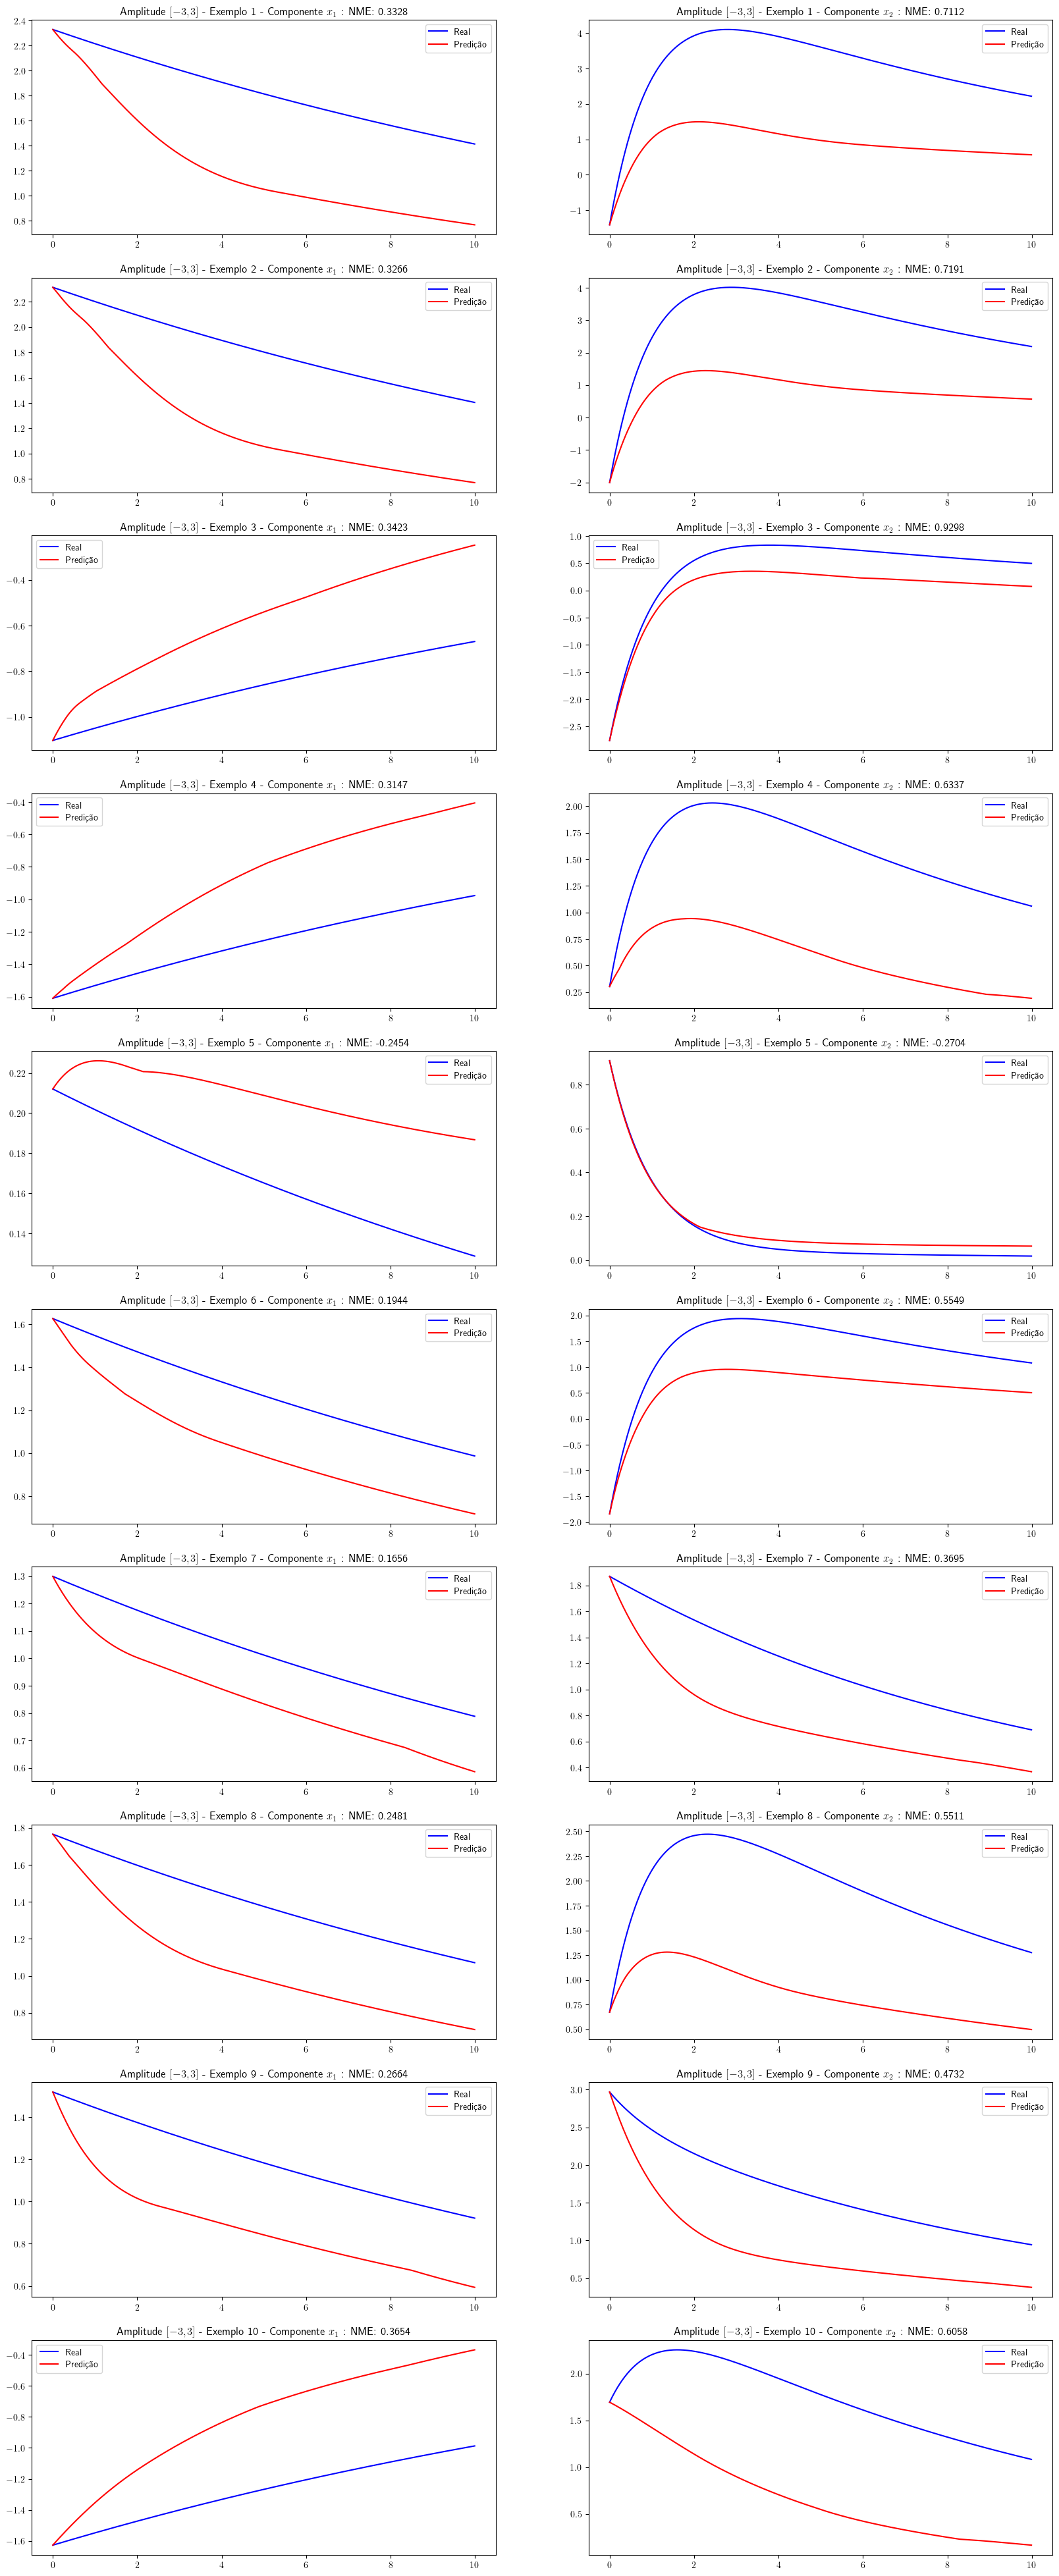

### Amplitude $x_0 \in [-5, 5]$

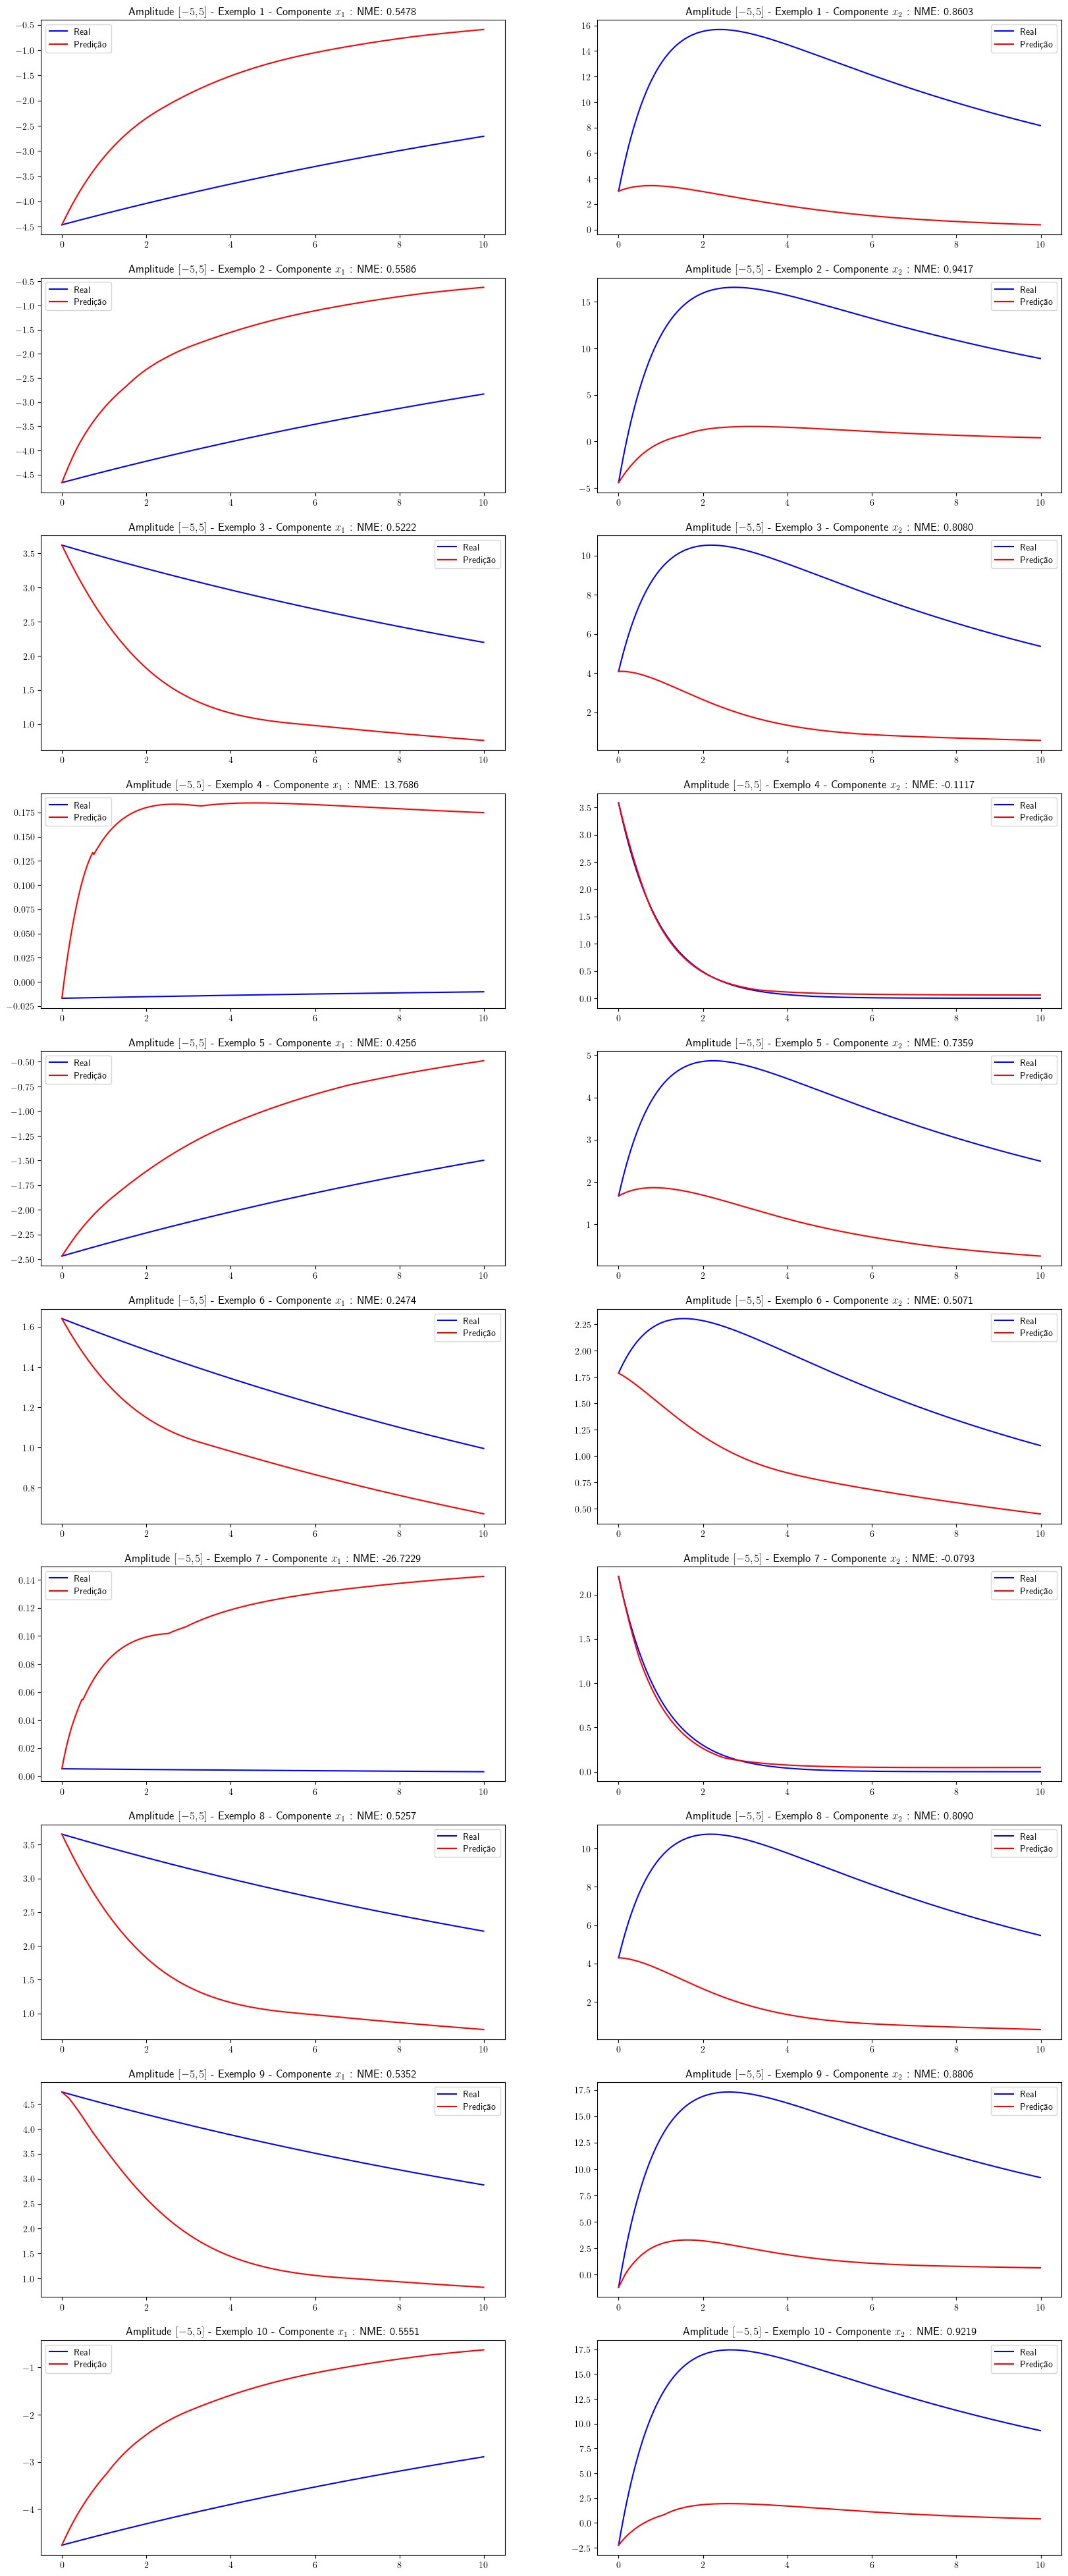

### Amplitude $x_0 \in [-10, 10]$

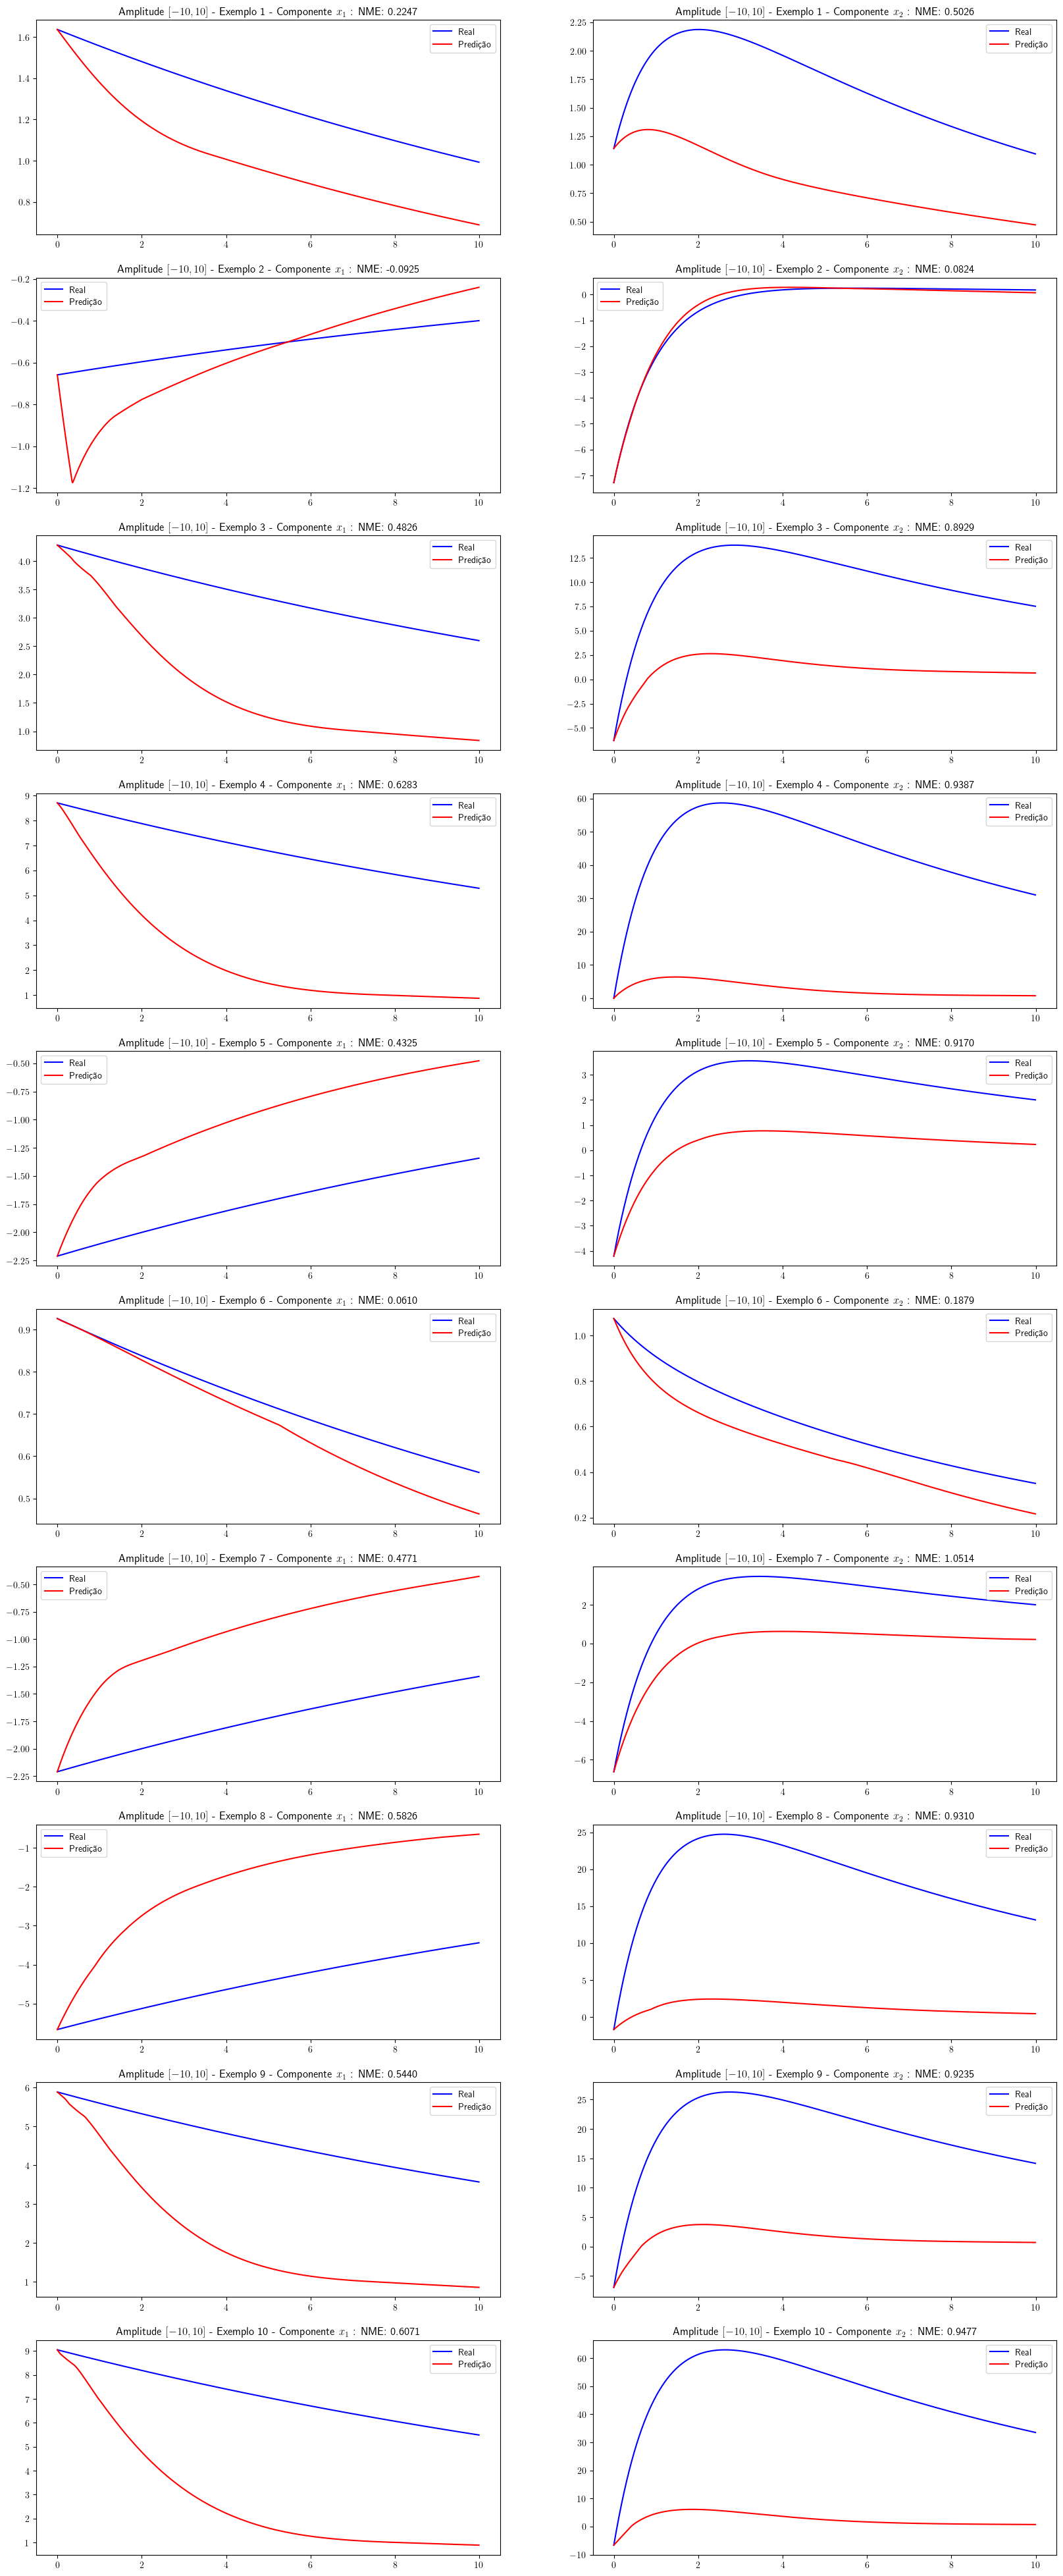


# Rede 3
## Parâmetros utilizados:
- Número de neurônios na camada 1: 9
- Função de ativação na camada 1: relu
- Número de neurônios na camada 2: 9
- Função de ativação na camada 2: relu
- Número de neurônios na camada 3: 8
- Função de ativação na camada 3: linear
- Taxa de aprendizado: 0.0038307470737355643


### Amplitude $x_0 \in [-1, 1]$

<Figure size 640x480 with 0 Axes>

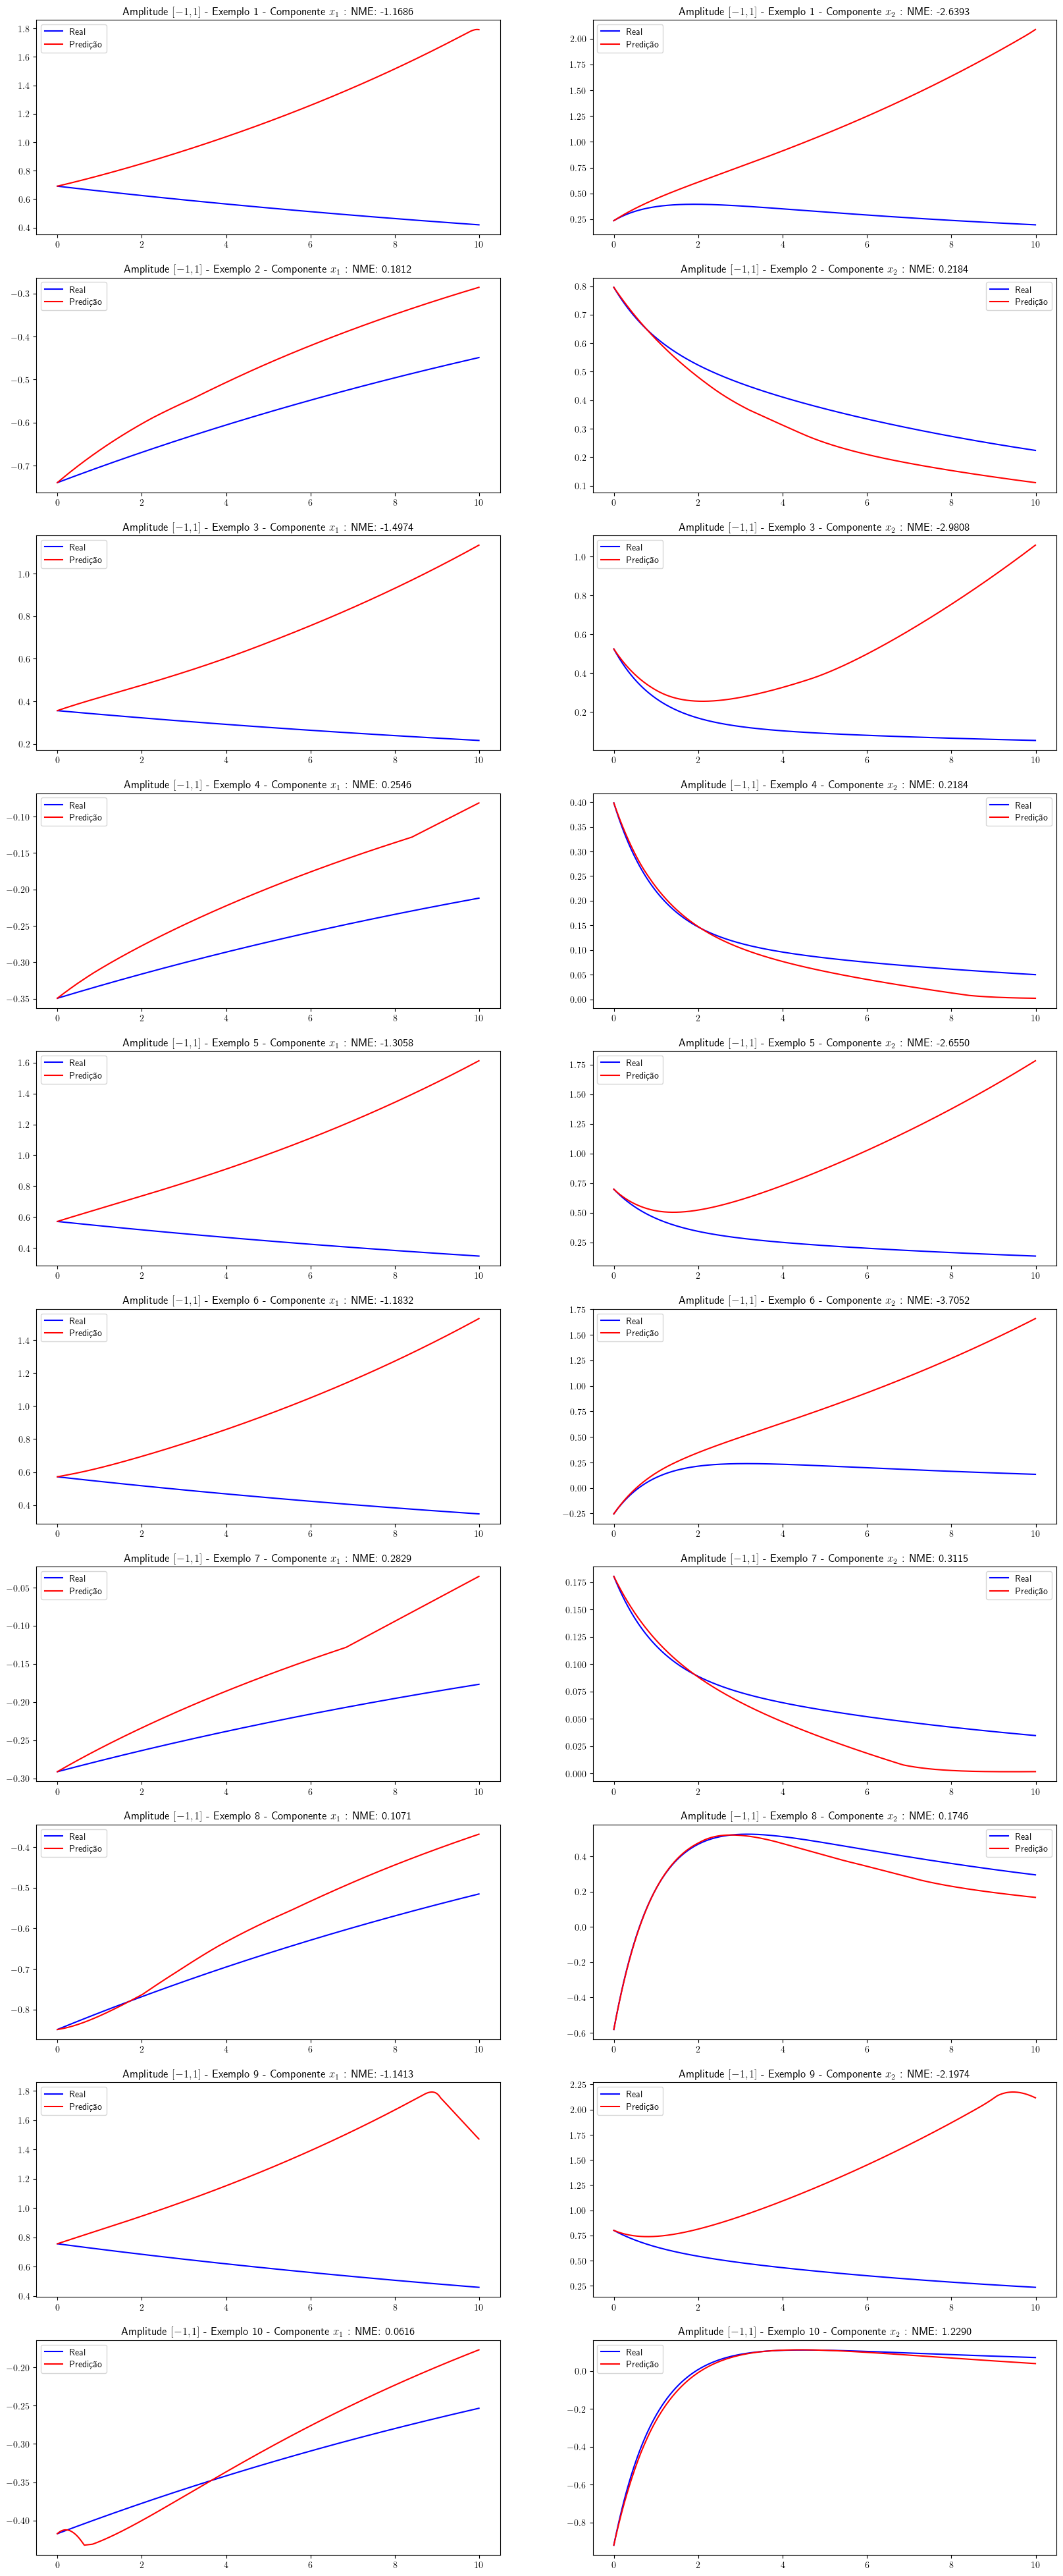

### Amplitude $x_0 \in [-3, 3]$

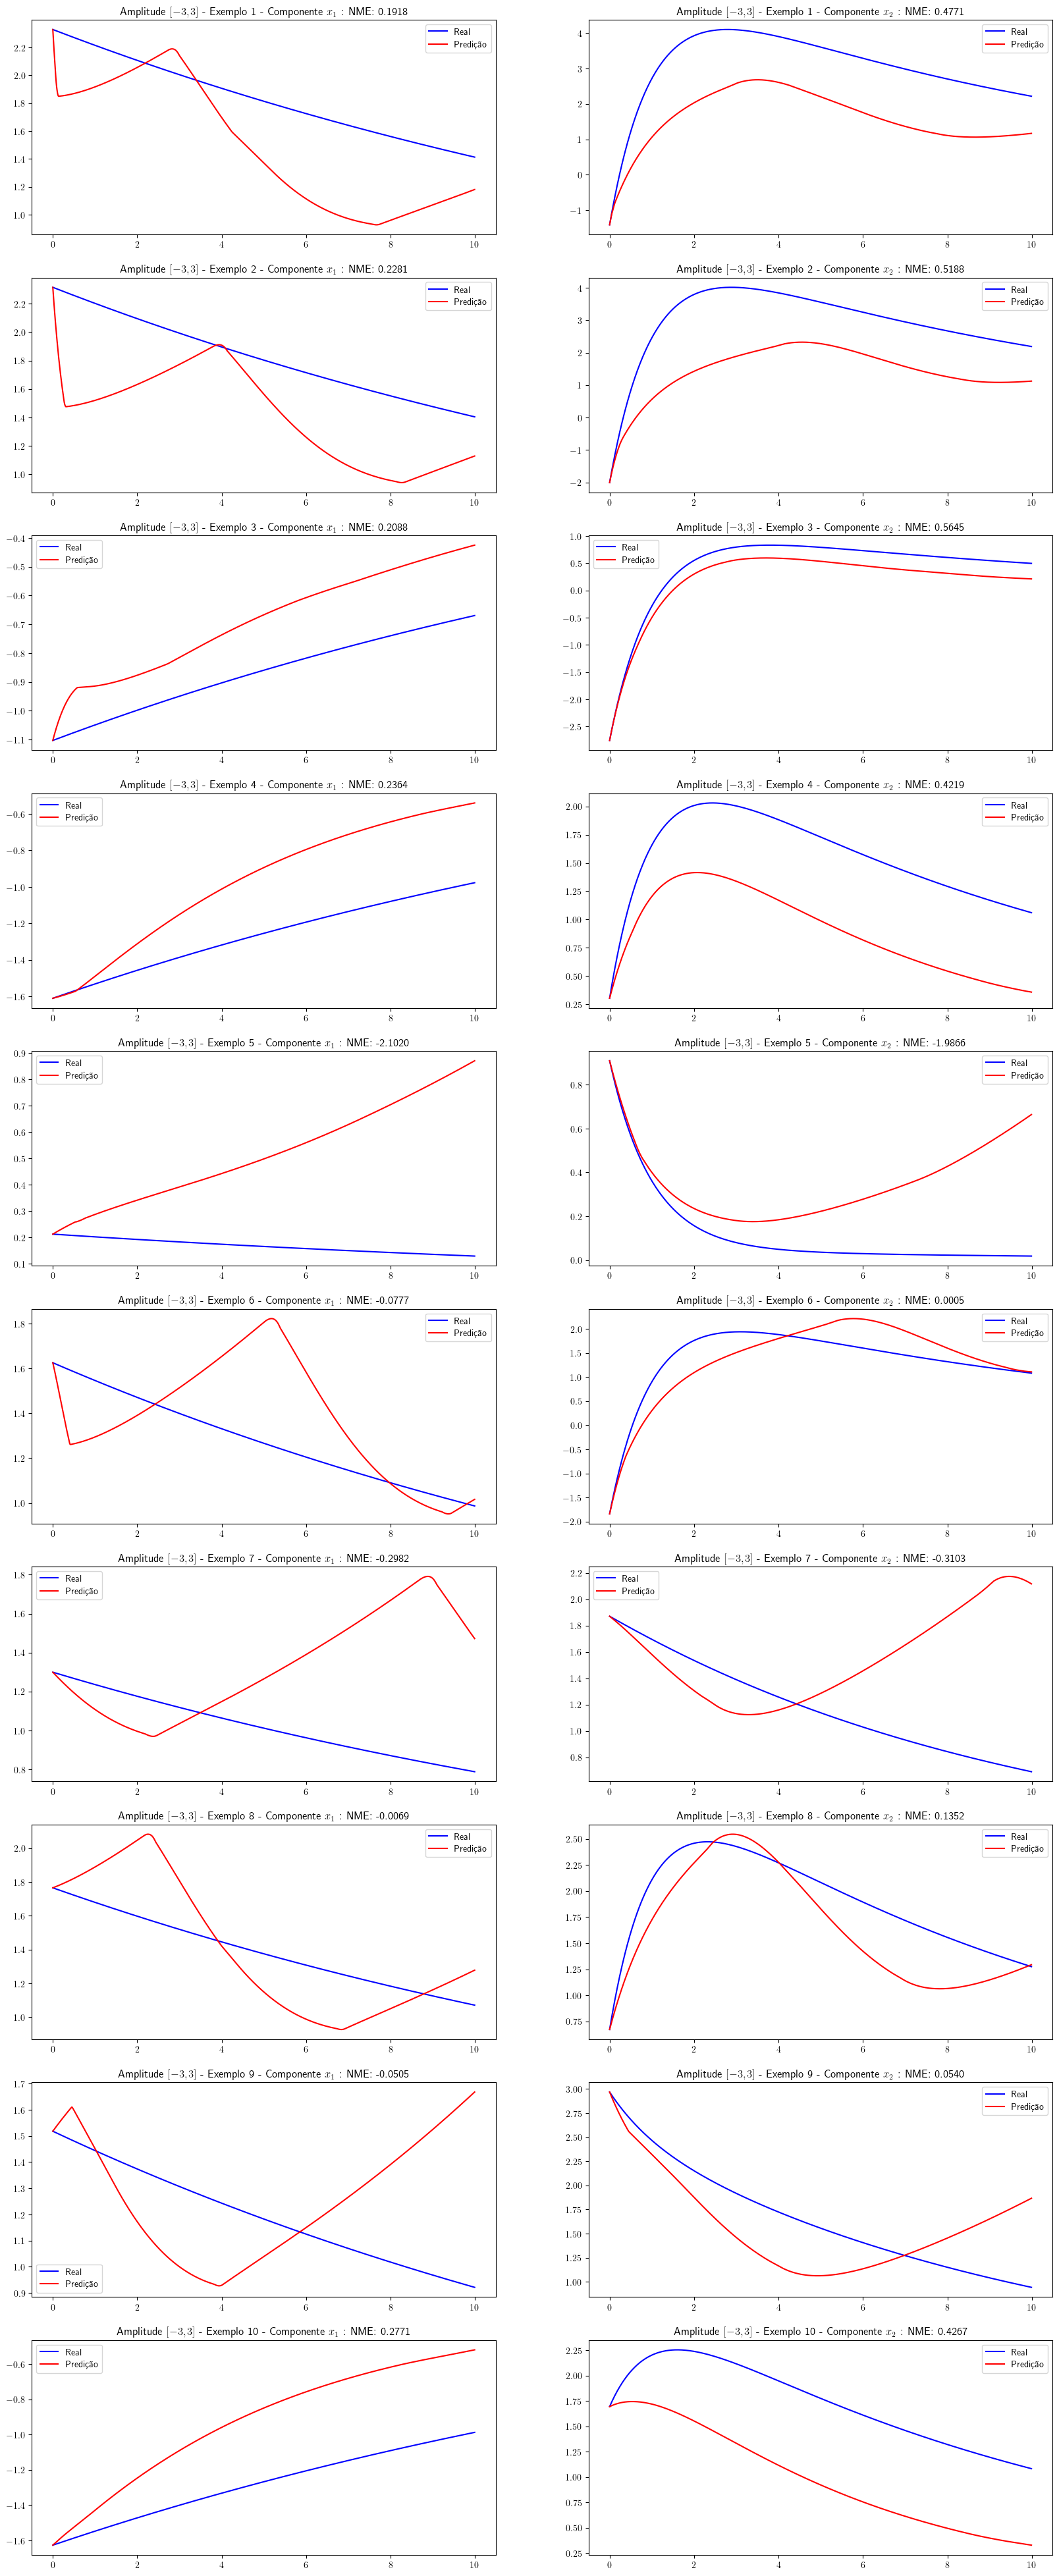

### Amplitude $x_0 \in [-5, 5]$

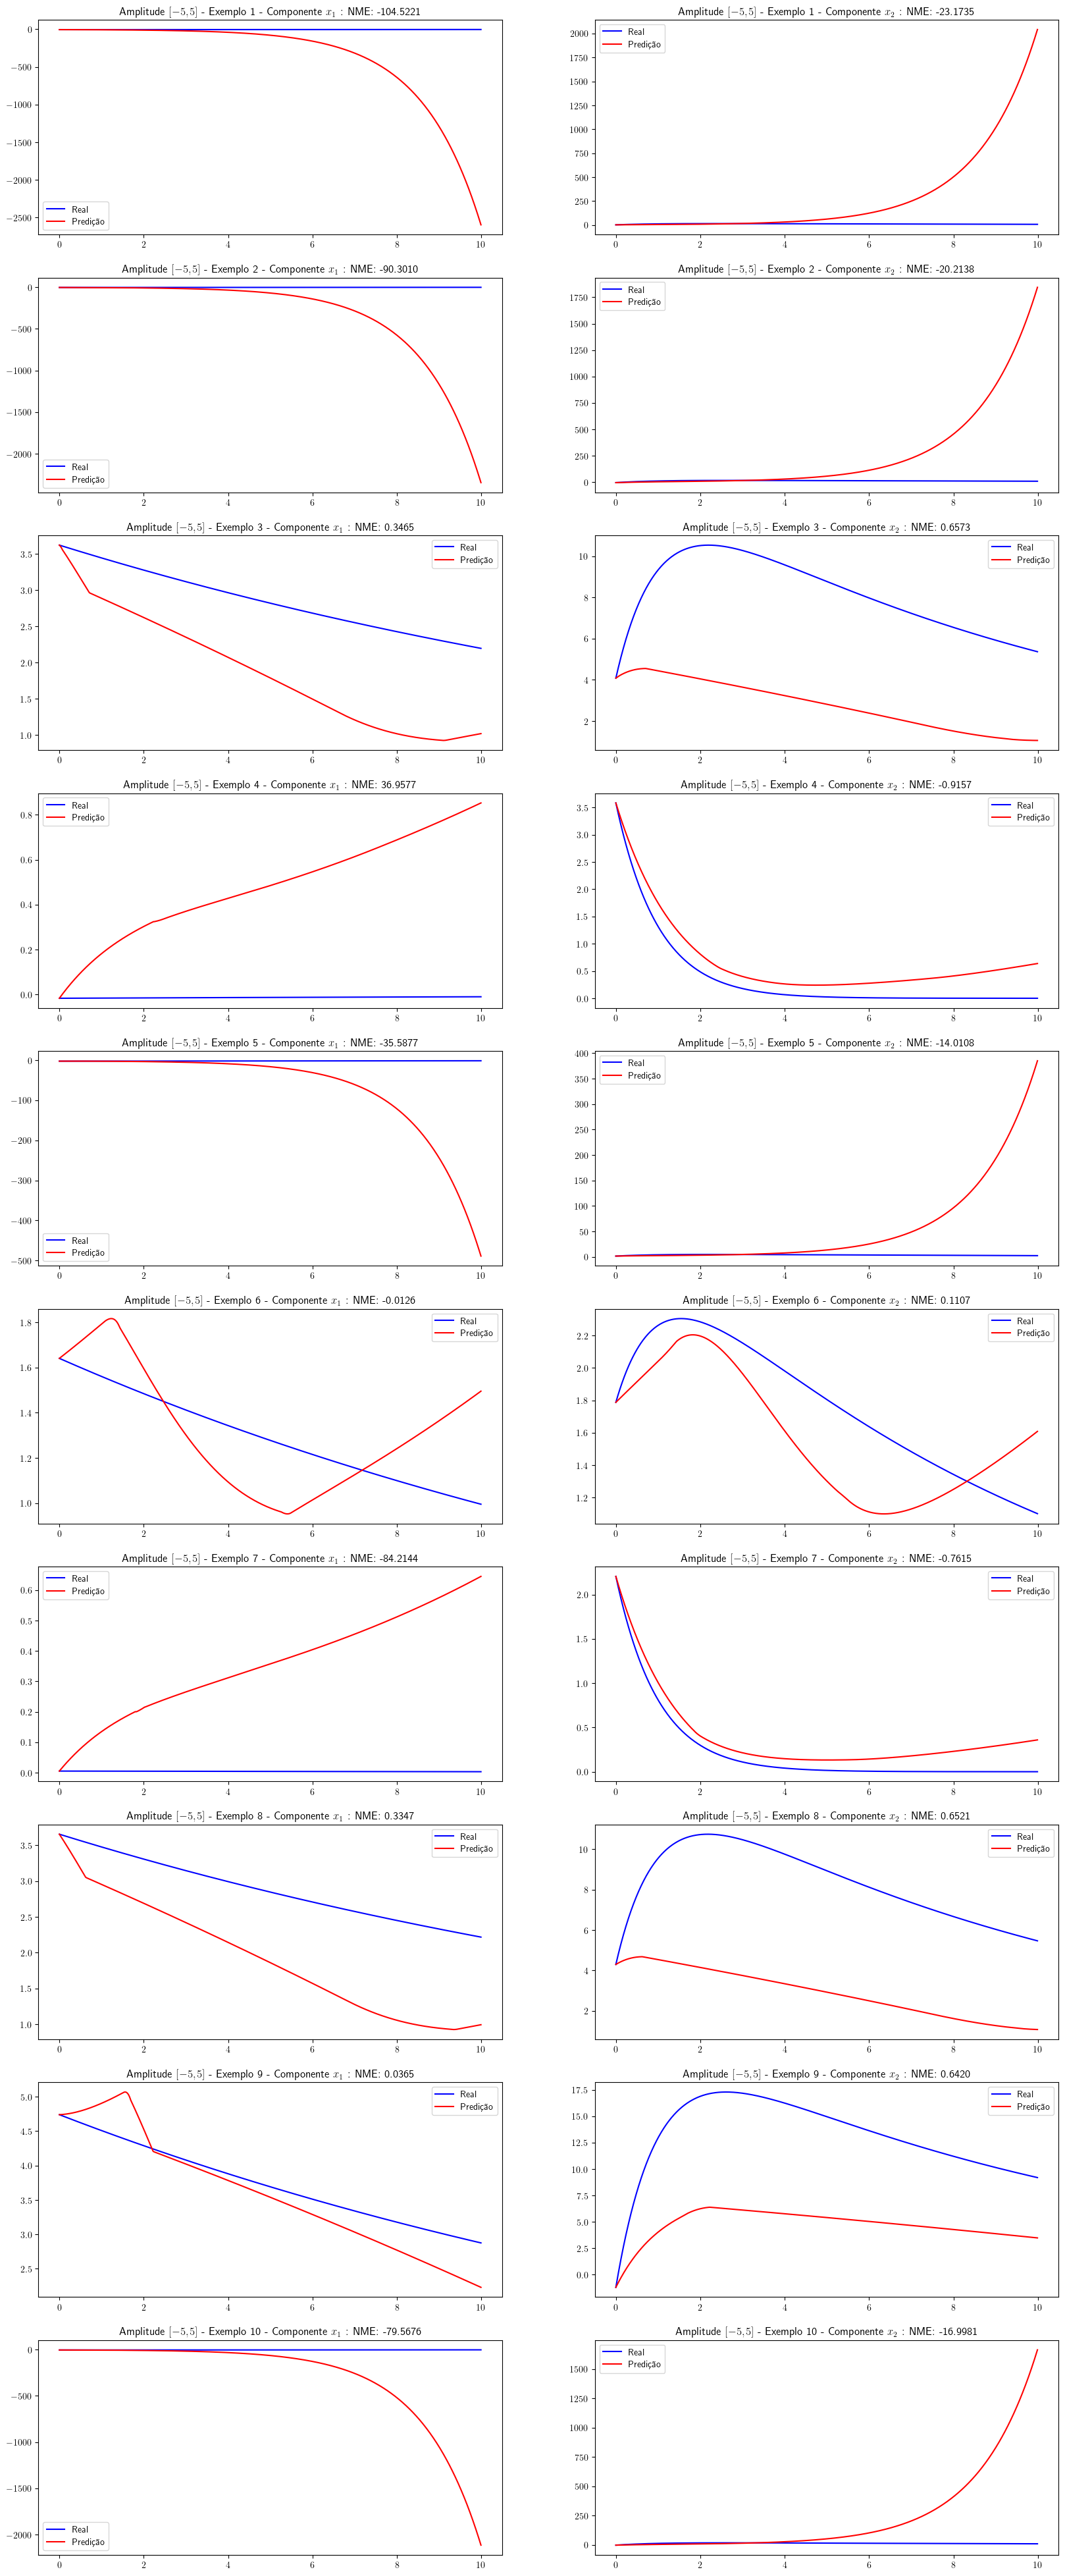

### Amplitude $x_0 \in [-10, 10]$

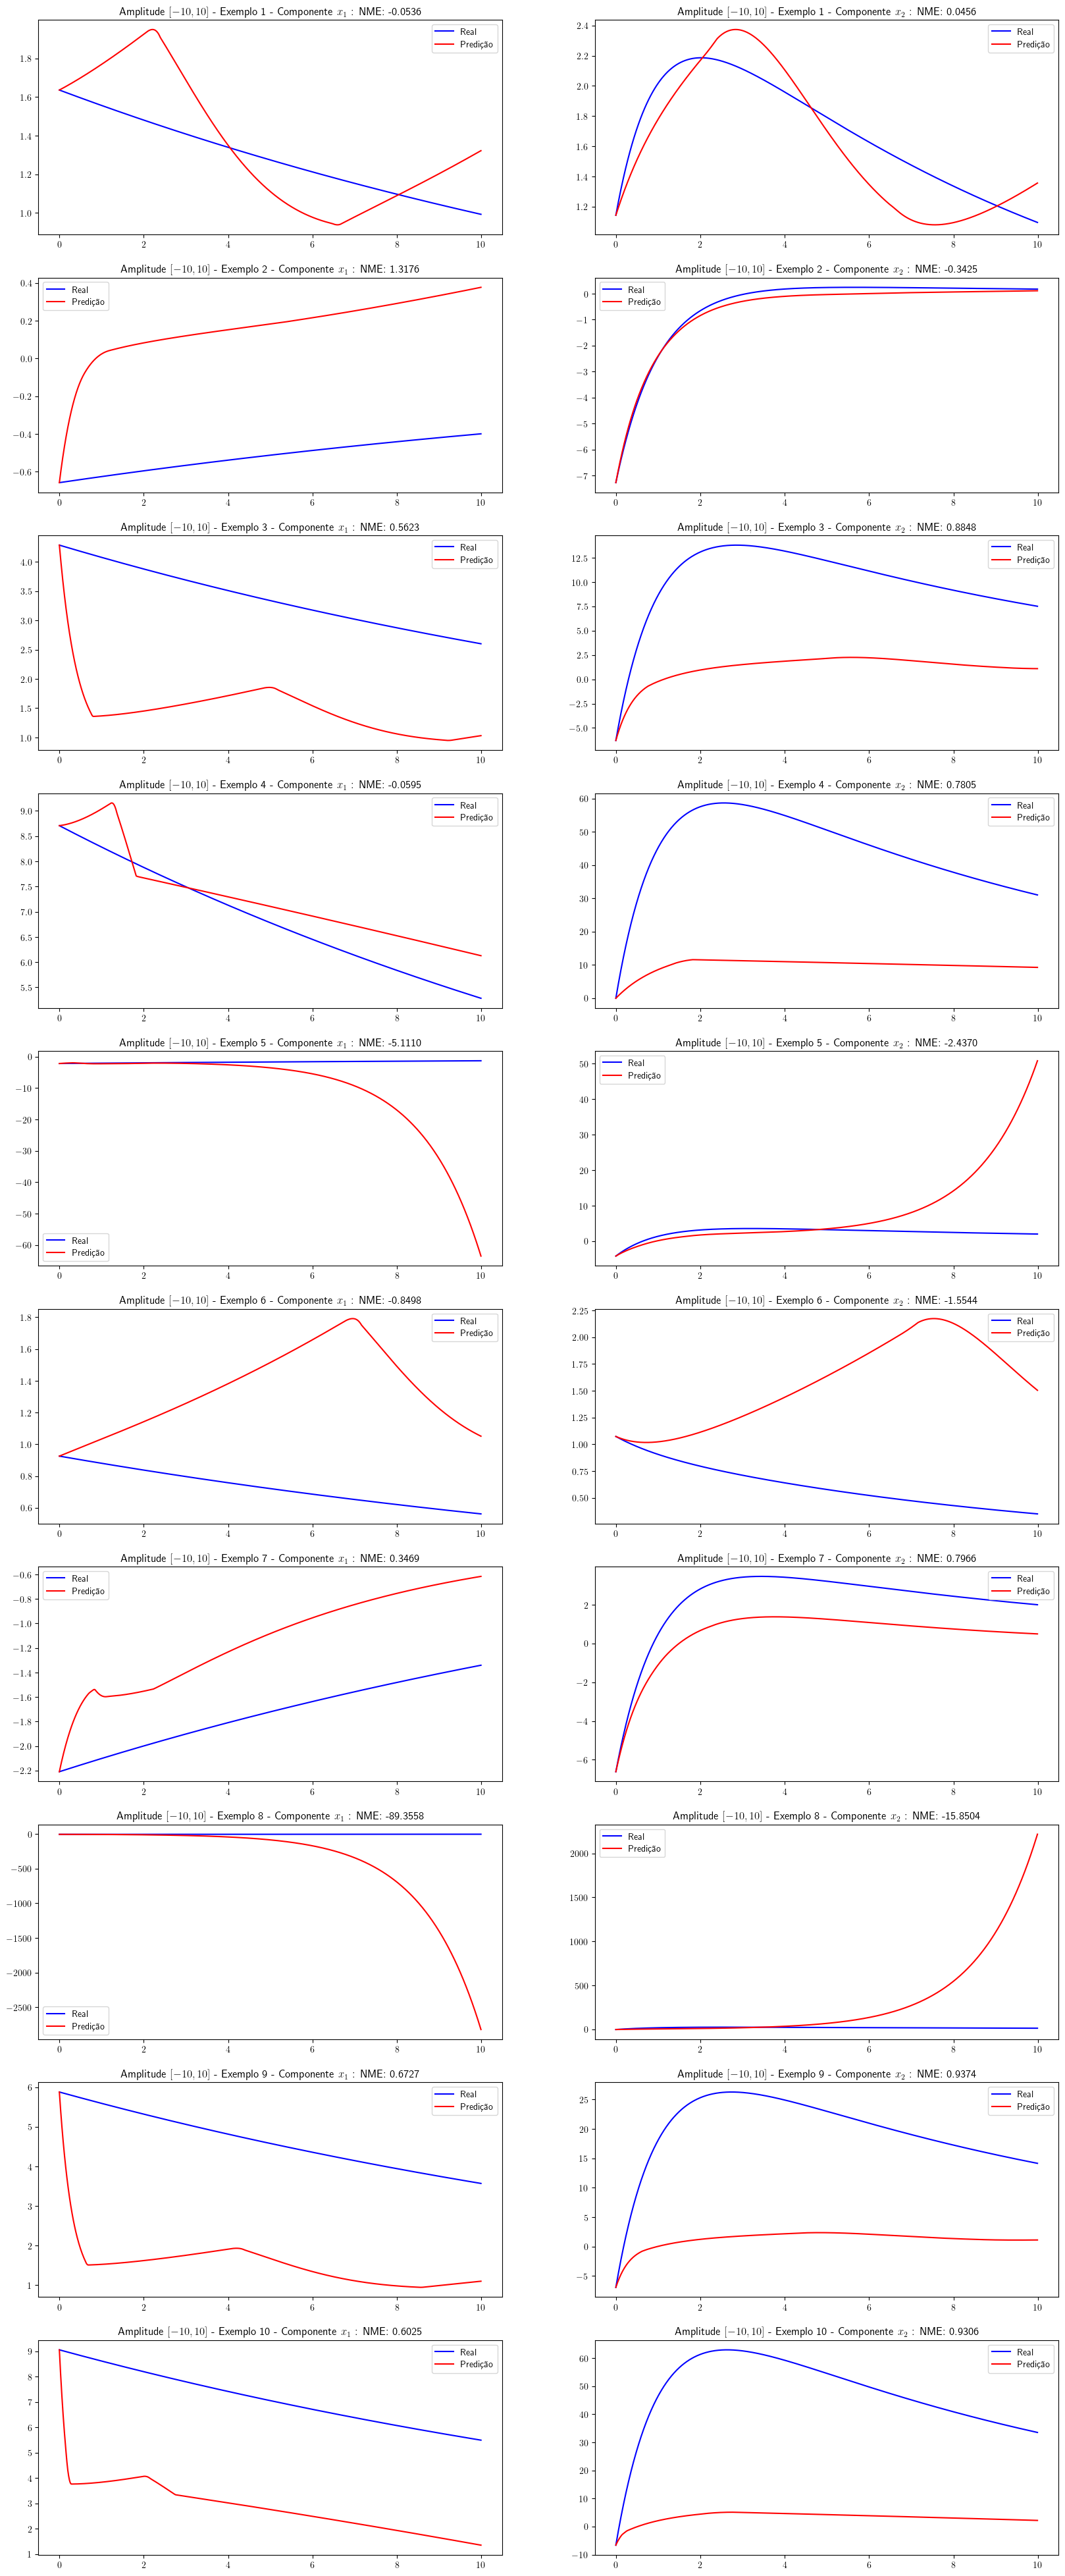

In [10]:
from matplotlib import pyplot as plt
from IPython.display import display, Markdown

plt.rcParams['text.usetex'] = True

components = ["x_1", "x_2"]
for i in range(3):
    display(Markdown(f"""
# Rede {i + 1}
## Parâmetros utilizados:
- Número de neurônios na camada 1: {int(best_three.iloc[i]['params_n_units_l1'])}
- Função de ativação na camada 1: {best_three.iloc[i]['params_activation_l1']}
- Número de neurônios na camada 2: {int(best_three.iloc[i]['params_n_units_l2'])}
- Função de ativação na camada 2: {best_three.iloc[i]['params_activation_l2']}
- Número de neurônios na camada 3: {int(best_three.iloc[i]['params_n_units_l3'])}
- Função de ativação na camada 3: {best_three.iloc[i]['params_activation_l3']}
- Taxa de aprendizado: {best_three.iloc[i]['params_learning_rate']}
"""), )
    figure = plt.figure()
    for bound in [1, 3, 5, 10]:
        display(Markdown(f"### Amplitude $x_0 \in [-{bound}, {bound}]$"))
        _, axis = plt.subplots(10, 2, figsize=(20, 50))
        for example in range(N_TEST_EXAMPLES):
            for j in range(2):
                nme = np.mean(x_validation[bound][example, :, j] - predictions[i][bound]
                              [example, :, j]) / np.mean(x_validation[bound][example, :, j])
                axis[example, j].plot(INTEGRATION_DOMAIN, x_validation[bound]
                                      [example, :, j], "b", label="Real")
                axis[example, j].plot(INTEGRATION_DOMAIN, predictions[i][bound]
                                      [example, :, j], "r", label="Predição")
                axis[example, j].legend()
                axis[example, j].set_title(
                    f"Amplitude $[-{bound}, {bound}]$ - Exemplo {example + 1} - Componente ${components[j]}$ : NME: {nme:.4f}")
        plt.show()